Modification en cours pour test DQN

#Imports

In [3]:
!pip install torch --quiet
!pip install ray --quiet
!pip install torch --quiet
!pip install tqdm --quiet
!pip install gymnasium --quiet
!pip install lz4 --quiet
!pip install gputil --quiet
!pip install ray[rllib] --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 MB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 6.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 925.5/925.5 kB 8.8 MB/s eta 0:00:00


In [4]:
import gymnasium as gym
import numpy as np
import scipy.ndimage as sm
import matplotlib.pyplot as plt

from tqdm import tqdm
import torch
import ray
from ray.rllib.algorithms import dqn
from ray.tune.registry import register_env
from ray.rllib.algorithms.algorithm import Algorithm
from ray import tune
import pandas as pd

/usr/local/lib/python3.10/dist-packages/flax/configurations.py:42: DeprecationWarning: jax.config.define_bool_state is deprecated. Please use other libraries for configuration instead.
  return jax_config.define_bool_state('flax_' + name, default, help)
/usr/local/lib/python3.10/dist-packages/flax/linen/activation.py:36: DeprecationWarning: jax.nn.normalize is deprecated. Use jax.nn.standardize instead.
  from jax.nn import normalize
/usr/local/lib/python3.10/dist-packages/tensorflow_probability/python/__init__.py:57: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if (distutils.version.LooseVersion(tf.__version__) <


In [5]:
from google.colab import drive
drive.mount('/content/drive')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Mounted at /content/drive


#Code de l'environnement

In [28]:
# Classe principale de l'env avec consigne
class SetpointWrapper(gym.Wrapper):
    def __init__(self,
                 config = {
                     "env":None,
                     "mode":0,
                     "classic":False,
                     "dim":None}):
      self.env = gym.make(config["env"])
      super().__init__(self.env)
      #assert config["mode"] in range(4), "il existe seulement 3 modes : 0, 1 et 2"
      #assert dim in [None,range(env.observation_space.shape[0])], "il existe "+env.observation_space.shape[0]+" dimensions"

      self._max_episode_steps=self.env._max_episode_steps
      self.mode = config["mode"]  # Mode de l'env
      self.taux_r = 48
      self._elapsed_steps = 0
      self.choice_state(config["dim"])  # Fonction choix de variable + definition du min-max
      self.set_setpoint()  # Fonction choix de la consigne en fonction du mode
      self.classic = config['classic']

      self.previous_state = None  # Memoire state
      self.previous_action = None # Memoire action

      # Modification de l'espace d'observation
      if self.classic : self.observation_space = self.observation_space = gym.spaces.Box(low=np.array([-np.inf, self.env.observation_space.low[1], self.env.observation_space.low[2], self.env.observation_space.low[3]], dtype=np.float32), high=np.array([np.inf, self.env.observation_space.high[1], self.env.observation_space.high[2], self.env.observation_space.high[3]], dtype=np.float32)) #a modifier
      else : self.observation_space = gym.spaces.Box(low=np.array([0., self.setmin_base, self.setmin_base, self.setmin_base], dtype=np.float32), high=np.array([1., self.setmax_base, self.setmax_base, self.setmax_base], dtype=np.float32))
      self.action_space = self.env.action_space #gym.spaces.Discrete(2)  # Modification de l'espace d'action

    def choice_state(self, dimension=None):
      state_box = self.env.observation_space
      # possible dimension (E fini)
      if dimension is None:
          dim = np.where((state_box.high - state_box.low) != np.inf)[0]
          self.chosen_state = np.random.choice(dim)
          print(self.chosen_state)
      else :
          self.chosen_state = dimension
      # boundary
      self.setmin_base = state_box.low[self.chosen_state] # Limite observation
      self.setmin = state_box.low[self.chosen_state]/2 # Division afin d'être dans les même conditions que le mode non personalisé
      self.setmax_base = state_box.high[self.chosen_state]
      self.setmax = state_box.high[self.chosen_state]/2
      if self.mode>-1:
        self.taux_r = 0.1*(self.setmax-self.setmin)
        self.setmax-= self.taux_r
        self.setmin+= self.taux_r

    # Génération du signal d'entrée (consigne) aléatoire
    def signal_generator(self, N, epsilon=0.05):
        a = (1 - 2*epsilon)
        # smoother
        s = np.random.randint(1,N//10)
        # random
        r = np.random.random(N)
        # smooth signal
        smooth = sm.gaussian_filter1d(r, s)
        n = a*(smooth - smooth.min())/(smooth.max() - smooth.min()) + epsilon
        return n

    def set_setpoint(self, epsilon=0.05):
        # modes
        if self.mode < 1  :
            self.setpoint = 0
        elif self.mode == 1 :
            self.setpoint = np.random.uniform(self.setmin, self.setmax)
        else :
            consigne = self.signal_generator(self._max_episode_steps+5, epsilon=0.05) # def pour nb max iter
            self.all_setpoint = (self.setmax - self.setmin)*consigne + self.setmin # rescale de  0-1 vers valeurs cibles
            self.setpoint = self.all_setpoint[1]

    # Fonction qui retourne le bon format d'observation
    def obs_mode(self, state, init=False):
      # classic, Constant or setpoint
      if self.mode == 2 :
        self.setpoint = self.all_setpoint[self._elapsed_steps+1]
      if init :
        self.previous_state = state[self.chosen_state]
        self.previous_action = self.action_space.sample()
      obs = np.array([self.previous_action, state[self.chosen_state], self.previous_state, self.setpoint])
      self.previous_state = state[self.chosen_state]
      return obs

    # Fonction reset
    def reset(self, seed=None, options=None):
      state, _ = self.env.reset()
      obs = self.obs_mode(state, init=True)
      self._elapsed_steps = 0 # reset steps
      self.set_setpoint() # reset setpoint
      return obs, {}

    # Fonction step avec gestion des arrets d'episode
    def step(self, action):
      self._elapsed_steps+=1
      state, reward, terminated, truncated, info = self.env.step(action)
      if self.classic:
        obs = state
      else : obs = self.obs_mode(state)
      self.previous_action = action
      # si mode -1 alors classique sinon gestion
      pos_pole = state[2]
      #gestion du terminated
      if self.mode>-1 :
        terminated = (pos_pole < self.setmin-self.taux_r or pos_pole > self.setmax+self.taux_r)
        if self.setpoint-self.taux_r>pos_pole or pos_pole>self.setpoint+self.taux_r:
          reward=0.1
        else : reward=1.
      else : terminated = (pos_pole < self.setmin or pos_pole > self.setmax)
      return obs, reward, terminated, truncated, info

#Tests avant entraînement

0
[0.         0.03544086 0.03502183 0.15057559] 0.1675516128540039 0.1924634965206714 0.1 False 0.04188790321350098
1
[1.         0.03023127 0.03544086 0.15035264] 0.1675516128540039 0.1922405449667437 0.1 False 0.04188790321350098
2
[1.         0.01939574 0.03023127 0.15005648] 0.1675516128540039 0.1919443796761795 0.1 False 0.04188790321350098
3
[1.         0.00290009 0.01939574 0.14970254] 0.1675516128540039 0.19159044398627567 0.1 False 0.04188790321350098
4
[ 1.         -0.01932597  0.00290009  0.14927322] 0.1675516128540039 0.19116111898805244 0.1 False 0.04188790321350098
5
[ 0.         -0.0356802  -0.01932597  0.148767  ] 0.1675516128540039 0.19065490207030944 0.1 False 0.04188790321350098
6
[ 0.         -0.04630359 -0.0356802   0.14820202] 0.1675516128540039 0.19008992243577305 0.1 False 0.04188790321350098
7
[ 0.         -0.05130238 -0.04630359  0.14757069] 0.1675516128540039 0.18945859207656568 0.1 False 0.04188790321350098
8
[ 0.         -0.05074665 -0.05130238  0.14686651]

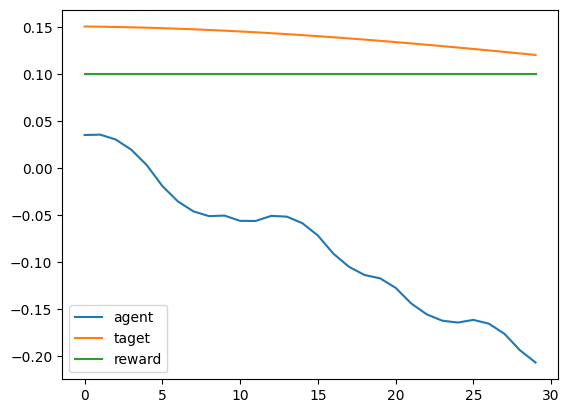

3.0000000000000013


In [50]:
#Config wrapper
setconfig = {
    "env":"CartPole-v1",
    "mode":2,
    "classic":False,
    "dim":2}

# Environment
env_ = SetpointWrapper(setconfig)

# simulation
for j in range (1):
  state, _ = env_.reset()
  Y =  [state[2:]] #[[state[2],0]]
  R = []
  for i in range(env_._max_episode_steps-2) :
    print(env_._elapsed_steps)
    action = env_.action_space.sample()  #algo0.compute_single_action(state)
    state, reward, done, _, info = env_.step(action)
    Y += [state[2:]] #[[state[2],0]]
    R += [reward]
    print(state, env_.setmax, env_.setpoint+env_.taux_r, reward, done, env_.taux_r)
    if done : break

  # plot
  plt.plot(range(env_._elapsed_steps), Y[1:], label=["agent","taget"])
  plt.plot(range(env_._elapsed_steps), R, label='reward')
  plt.legend()
  plt.show()
  print(sum(R))

#Ray initialisation

In [51]:
ray.init()

2024-01-12 22:09:18,419	INFO worker.py:1724 -- Started a local Ray instance.


Python version:,3.10.12
Ray version:,2.9.0


In [23]:
ray.shutdown()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [58]:
#Config environnement
setconfig = {
    "env":"CartPole-v1",
    "mode":-1,
    "classic":False,
    "dim":2}

In [59]:
#Enregistrement de l'environnement custom pour tune
register_env("custom_env", lambda config: SetpointWrapper(setconfig))

#Entraînement

In [60]:
#Configuration de tune (on lui donne le nom de l'environnement modifié)
config = {
    "env": "custom_env",
    "framework": "torch",
    "num_gpus": 0,
    "num_workers":1
}

analysis = tune.run(
    dqn.DQN,
    config=config,
    stop={"episode_reward_mean": 300,
          "episodes_total": 1000
          },
    checkpoint_at_end=True,
    checkpoint_freq=25,
    #metric="td_error",
    #resume=True,
    local_dir="/content/drive/MyDrive/Stage_M2/Resultats_rllib",
    name="dqn_cartpole_setpoint_mode_"+str(setconfig['mode'])+"_sanslimite")

2024-01-12 23:38:08,423	INFO tune.py:592 -- [output] This will use the new output engine with verbosity 2. To disable the new output and use the legacy output engine, set the environment variable RAY_AIR_NEW_OUTPUT=0. For more information, please see https://github.com/ray-project/ray/issues/36949
/usr/local/lib/python3.10/dist-packages/ray/tune/tune.py:655: DeprecationWarning: checkpoint_freq is deprecated and will be removed. use checkpoint_config.checkpoint_frequency instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/ray/tune/tune.py:662: DeprecationWarning: checkpoint_at_end is deprecated and will be removed. use checkpoint_config.checkpoint_at_end instead.
  warnings.warn(


+-----------------------------------------------------------------------------+
| Configuration for experiment     dqn_cartpole_setpoint_mode_-1_sanslimite   |
+-----------------------------------------------------------------------------+
| Search algorithm                 BasicVariantGenerator                      |
| Scheduler                        FIFOScheduler                              |
| Number of trials                 1                                          |
+-----------------------------------------------------------------------------+

View detailed results here: /content/drive/MyDrive/Stage_M2/Resultats_rllib/dqn_cartpole_setpoint_mode_-1_sanslimite
To visualize your results with TensorBoard, run: `tensorboard --logdir /content/drive/MyDrive/Stage_M2/Resultats_rllib/dqn_cartpole_setpoint_mode_-1_sanslimite`

Trial status: 1 PENDING
Current time: 2024-01-12 23:38:08. Total running time: 0s
Logical resource usage: 0/2 CPUs, 0/0 GPUs
+----------------------------------

(pid=40019) /usr/local/lib/python3.10/dist-packages/pkg_resources/__init__.py:121: DeprecationWarning: pkg_resources is deprecated as an API
(pid=40019)   warnings.warn("pkg_resources is deprecated as an API", DeprecationWarning)
(pid=40019) /usr/local/lib/python3.10/dist-packages/pkg_resources/__init__.py:2870: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google')`.
(pid=40019) Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
(pid=40019)   declare_namespace(pkg)
(pid=40019) /usr/local/lib/python3.10/dist-packages/pkg_resources/__init__.py:2870: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google.cloud')`.
(pid=40019) Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/late


Trial DQN_custom_env_a4013_00000 started with configuration:
+--------------------------------------------------------+
| Trial DQN_custom_env_a4013_00000 config                |
+--------------------------------------------------------+
| env                                         custom_env |
| framework                                        torch |
| num_gpus                                             0 |
| num_workers                                          1 |
+--------------------------------------------------------+


(DQN pid=40019) Trainable.setup took 12.665 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.



Trial status: 1 RUNNING
Current time: 2024-01-12 23:38:38. Total running time: 30s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+---------------------------------------+
| Trial name                   status   |
+---------------------------------------+
| DQN_custom_env_a4013_00000   RUNNING  |
+---------------------------------------+

Trial DQN_custom_env_a4013_00000 finished iteration 1 at 2024-01-12 23:38:42. Total running time: 34s
+-----------------------------------------------------+
| Trial DQN_custom_env_a4013_00000 result             |
+-----------------------------------------------------+
| episodes_total                                   47 |
| num_env_steps_sampled                          1000 |
| num_env_steps_trained                             0 |
| sampler_results/episode_len_mean            21.2128 |
| sampler_results/episode_reward_mean         21.2128 |
+-----------------------------------------------------+


(DQN pid=40019) 2024-01-12 23:38:42,832	WARNING deprecation.py:50 -- DeprecationWarning: `ray.rllib.execution.train_ops.multi_gpu_train_one_step` has been deprecated. This will raise an error in the future!



Trial status: 1 RUNNING
Current time: 2024-01-12 23:39:08. Total running time: 1min 0s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                   status       iter     total time (s)     ts     reward     episode_reward_max     episode_reward_min     episode_len_mean     episodes_this_iter |
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| DQN_custom_env_a4013_00000   RUNNING         1            8.69901   1000    21.2128                     73                     10              21.2128                     47 |
+----------------------------------------------------------------------------------------------------------------------------------------------------------

(RolloutWorker pid=40095) /usr/local/lib/python3.10/dist-packages/gymnasium/envs/classic_control/cartpole.py:180: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
(RolloutWorker pid=40095)   logger.warn(



Trial DQN_custom_env_a4013_00000 finished iteration 8 at 2024-01-12 23:45:00. Total running time: 6min 51s
+----------------------------------------------------+
| Trial DQN_custom_env_a4013_00000 result            |
+----------------------------------------------------+
| episodes_total                                 323 |
| num_env_steps_sampled                         8000 |
| num_env_steps_trained                       224000 |
| sampler_results/episode_len_mean             33.33 |
| sampler_results/episode_reward_mean          31.32 |
+----------------------------------------------------+

Trial status: 1 RUNNING
Current time: 2024-01-12 23:45:09. Total running time: 7min 0s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                   status       iter     total time (s)     ts     reward 

(RolloutWorker pid=40095) /usr/local/lib/python3.10/dist-packages/gymnasium/envs/classic_control/cartpole.py:180: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
(RolloutWorker pid=40095)   logger.warn(



Trial DQN_custom_env_a4013_00000 finished iteration 9 at 2024-01-12 23:45:54. Total running time: 7min 46s
+----------------------------------------------------+
| Trial DQN_custom_env_a4013_00000 result            |
+----------------------------------------------------+
| episodes_total                                 326 |
| num_env_steps_sampled                         9000 |
| num_env_steps_trained                       256000 |
| sampler_results/episode_len_mean             37.92 |
| sampler_results/episode_reward_mean          35.91 |
+----------------------------------------------------+

Trial status: 1 RUNNING
Current time: 2024-01-12 23:46:09. Total running time: 8min 0s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                   status       iter     total time (s)     ts     reward 

(RolloutWorker pid=40095) /usr/local/lib/python3.10/dist-packages/gymnasium/envs/classic_control/cartpole.py:180: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
(RolloutWorker pid=40095)   logger.warn(
(RolloutWorker pid=40095) /usr/local/lib/python3.10/dist-packages/gymnasium/envs/classic_control/cartpole.py:180: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
(RolloutWorker pid=40095)   logger.warn(


Trial status: 1 RUNNING
Current time: 2024-01-12 23:46:39. Total running time: 8min 31s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                   status       iter     total time (s)     ts     reward     episode_reward_max     episode_reward_min     episode_len_mean     episodes_this_iter |
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| DQN_custom_env_a4013_00000   RUNNING         9            440.286   9000      35.91                    500                      8                37.92                      3 |
+----------------------------------------------------------------------------------------------------------------------------------------------------------

(RolloutWorker pid=40095) /usr/local/lib/python3.10/dist-packages/gymnasium/envs/classic_control/cartpole.py:180: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
(RolloutWorker pid=40095)   logger.warn(
(RolloutWorker pid=40095) /usr/local/lib/python3.10/dist-packages/gymnasium/envs/classic_control/cartpole.py:180: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
(RolloutWorker pid=40095)   logger.warn(


Trial status: 1 RUNNING
Current time: 2024-01-12 23:47:39. Total running time: 9min 31s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                   status       iter     total time (s)      ts     reward     episode_reward_max     episode_reward_min     episode_len_mean     episodes_this_iter |
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| DQN_custom_env_a4013_00000   RUNNING        10            492.728   10000       42.8                    500                      8                47.41                      3 |
+------------------------------------------------------------------------------------------------------------------------------------------------------

(RolloutWorker pid=40095) /usr/local/lib/python3.10/dist-packages/gymnasium/envs/classic_control/cartpole.py:180: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
(RolloutWorker pid=40095)   logger.warn(



Trial status: 1 RUNNING
Current time: 2024-01-12 23:48:09. Total running time: 10min 1s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                   status       iter     total time (s)      ts     reward     episode_reward_max     episode_reward_min     episode_len_mean     episodes_this_iter |
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| DQN_custom_env_a4013_00000   RUNNING        11            548.872   11000      48.23                    500                      8                56.55                      3 |
+-----------------------------------------------------------------------------------------------------------------------------------------------------

(RolloutWorker pid=40095) /usr/local/lib/python3.10/dist-packages/gymnasium/envs/classic_control/cartpole.py:180: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
(RolloutWorker pid=40095)   logger.warn(



Trial DQN_custom_env_a4013_00000 finished iteration 12 at 2024-01-12 23:48:37. Total running time: 10min 29s
+----------------------------------------------------+
| Trial DQN_custom_env_a4013_00000 result            |
+----------------------------------------------------+
| episodes_total                                 335 |
| num_env_steps_sampled                        12000 |
| num_env_steps_trained                       352000 |
| sampler_results/episode_len_mean             67.72 |
| sampler_results/episode_reward_mean          55.46 |
+----------------------------------------------------+

Trial status: 1 RUNNING
Current time: 2024-01-12 23:48:39. Total running time: 10min 31s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                   status       iter     total time (s)      ts     r

(RolloutWorker pid=40095) /usr/local/lib/python3.10/dist-packages/gymnasium/envs/classic_control/cartpole.py:180: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
(RolloutWorker pid=40095)   logger.warn(


Trial status: 1 RUNNING
Current time: 2024-01-12 23:49:09. Total running time: 11min 1s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                   status       iter     total time (s)      ts     reward     episode_reward_max     episode_reward_min     episode_len_mean     episodes_this_iter |
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| DQN_custom_env_a4013_00000   RUNNING        12            603.314   12000      55.46                    500                      8                67.72                      3 |
+------------------------------------------------------------------------------------------------------------------------------------------------------

(RolloutWorker pid=40095) /usr/local/lib/python3.10/dist-packages/gymnasium/envs/classic_control/cartpole.py:180: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
(RolloutWorker pid=40095)   logger.warn(



Trial DQN_custom_env_a4013_00000 finished iteration 13 at 2024-01-12 23:49:36. Total running time: 11min 27s
+----------------------------------------------------+
| Trial DQN_custom_env_a4013_00000 result            |
+----------------------------------------------------+
| episodes_total                                 337 |
| num_env_steps_sampled                        13000 |
| num_env_steps_trained                       384000 |
| sampler_results/episode_len_mean             77.47 |
| sampler_results/episode_reward_mean          60.03 |
+----------------------------------------------------+

Trial status: 1 RUNNING
Current time: 2024-01-12 23:49:39. Total running time: 11min 31s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                   status       iter     total time (s)      ts     r

(RolloutWorker pid=40095) /usr/local/lib/python3.10/dist-packages/gymnasium/envs/classic_control/cartpole.py:180: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
(RolloutWorker pid=40095)   logger.warn(


Trial status: 1 RUNNING
Current time: 2024-01-12 23:50:09. Total running time: 12min 1s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                   status       iter     total time (s)      ts     reward     episode_reward_max     episode_reward_min     episode_len_mean     episodes_this_iter |
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| DQN_custom_env_a4013_00000   RUNNING        13            661.655   13000      60.03                    500                      8                77.47                      2 |
+------------------------------------------------------------------------------------------------------------------------------------------------------

(RolloutWorker pid=40095) /usr/local/lib/python3.10/dist-packages/gymnasium/envs/classic_control/cartpole.py:180: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
(RolloutWorker pid=40095)   logger.warn(



Trial DQN_custom_env_a4013_00000 finished iteration 14 at 2024-01-12 23:50:30. Total running time: 12min 22s
+----------------------------------------------------+
| Trial DQN_custom_env_a4013_00000 result            |
+----------------------------------------------------+
| episodes_total                                 339 |
| num_env_steps_sampled                        14000 |
| num_env_steps_trained                       416000 |
| sampler_results/episode_len_mean             86.57 |
| sampler_results/episode_reward_mean          61.59 |
+----------------------------------------------------+

Trial status: 1 RUNNING
Current time: 2024-01-12 23:50:39. Total running time: 12min 31s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                   status       iter     total time (s)      ts     r

(RolloutWorker pid=40095) /usr/local/lib/python3.10/dist-packages/gymnasium/envs/classic_control/cartpole.py:180: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
(RolloutWorker pid=40095)   logger.warn(


Trial status: 1 RUNNING
Current time: 2024-01-12 23:51:10. Total running time: 13min 1s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                   status       iter     total time (s)      ts     reward     episode_reward_max     episode_reward_min     episode_len_mean     episodes_this_iter |
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| DQN_custom_env_a4013_00000   RUNNING        14            715.835   14000      61.59                    500                      8                86.57                      2 |
+------------------------------------------------------------------------------------------------------------------------------------------------------

(RolloutWorker pid=40095) /usr/local/lib/python3.10/dist-packages/gymnasium/envs/classic_control/cartpole.py:180: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
(RolloutWorker pid=40095)   logger.warn(



Trial DQN_custom_env_a4013_00000 finished iteration 15 at 2024-01-12 23:51:25. Total running time: 13min 17s
+----------------------------------------------------+
| Trial DQN_custom_env_a4013_00000 result            |
+----------------------------------------------------+
| episodes_total                                 341 |
| num_env_steps_sampled                        15000 |
| num_env_steps_trained                       448000 |
| sampler_results/episode_len_mean             95.06 |
| sampler_results/episode_reward_mean          62.78 |
+----------------------------------------------------+

Trial status: 1 RUNNING
Current time: 2024-01-12 23:51:40. Total running time: 13min 31s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                   status       iter     total time (s)      ts     r

(RolloutWorker pid=40095) /usr/local/lib/python3.10/dist-packages/gymnasium/envs/classic_control/cartpole.py:180: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
(RolloutWorker pid=40095)   logger.warn(


Trial status: 1 RUNNING
Current time: 2024-01-12 23:52:10. Total running time: 14min 1s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                   status       iter     total time (s)      ts     reward     episode_reward_max     episode_reward_min     episode_len_mean     episodes_this_iter |
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| DQN_custom_env_a4013_00000   RUNNING        15            771.107   15000      62.78                    500                      8                95.06                      2 |
+------------------------------------------------------------------------------------------------------------------------------------------------------

(RolloutWorker pid=40095) /usr/local/lib/python3.10/dist-packages/gymnasium/envs/classic_control/cartpole.py:180: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
(RolloutWorker pid=40095)   logger.warn(



Trial DQN_custom_env_a4013_00000 finished iteration 16 at 2024-01-12 23:52:21. Total running time: 14min 13s
+----------------------------------------------------+
| Trial DQN_custom_env_a4013_00000 result            |
+----------------------------------------------------+
| episodes_total                                 343 |
| num_env_steps_sampled                        16000 |
| num_env_steps_trained                       480000 |
| sampler_results/episode_len_mean            104.32 |
| sampler_results/episode_reward_mean          64.45 |
+----------------------------------------------------+

Trial status: 1 RUNNING
Current time: 2024-01-12 23:52:40. Total running time: 14min 31s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                   status       iter     total time (s)      ts     r

(RolloutWorker pid=40095) /usr/local/lib/python3.10/dist-packages/gymnasium/envs/classic_control/cartpole.py:180: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
(RolloutWorker pid=40095)   logger.warn(


Trial status: 1 RUNNING
Current time: 2024-01-12 23:53:10. Total running time: 15min 1s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                   status       iter     total time (s)      ts     reward     episode_reward_max     episode_reward_min     episode_len_mean     episodes_this_iter |
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| DQN_custom_env_a4013_00000   RUNNING        16            826.929   16000      64.45                    500                      8               104.32                      2 |
+------------------------------------------------------------------------------------------------------------------------------------------------------

(RolloutWorker pid=40095) /usr/local/lib/python3.10/dist-packages/gymnasium/envs/classic_control/cartpole.py:180: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
(RolloutWorker pid=40095)   logger.warn(



Trial status: 1 RUNNING
Current time: 2024-01-12 23:53:40. Total running time: 15min 31s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                   status       iter     total time (s)      ts     reward     episode_reward_max     episode_reward_min     episode_len_mean     episodes_this_iter |
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| DQN_custom_env_a4013_00000   RUNNING        17            880.057   17000      68.28                    500                      8               114.48                      4 |
+----------------------------------------------------------------------------------------------------------------------------------------------------

(RolloutWorker pid=40095) /usr/local/lib/python3.10/dist-packages/gymnasium/envs/classic_control/cartpole.py:180: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
(RolloutWorker pid=40095)   logger.warn(



Trial status: 1 RUNNING
Current time: 2024-01-12 23:54:40. Total running time: 16min 31s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                   status       iter     total time (s)      ts     reward     episode_reward_max     episode_reward_min     episode_len_mean     episodes_this_iter |
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| DQN_custom_env_a4013_00000   RUNNING        18            936.743   18000      74.03                    500                      8               120.38                      6 |
+----------------------------------------------------------------------------------------------------------------------------------------------------

(RolloutWorker pid=40095) /usr/local/lib/python3.10/dist-packages/gymnasium/envs/classic_control/cartpole.py:180: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
(RolloutWorker pid=40095)   logger.warn(



Trial DQN_custom_env_a4013_00000 finished iteration 19 at 2024-01-12 23:55:03. Total running time: 16min 55s
+----------------------------------------------------+
| Trial DQN_custom_env_a4013_00000 result            |
+----------------------------------------------------+
| episodes_total                                 355 |
| num_env_steps_sampled                        19000 |
| num_env_steps_trained                       576000 |
| sampler_results/episode_len_mean            130.06 |
| sampler_results/episode_reward_mean          80.75 |
+----------------------------------------------------+

Trial status: 1 RUNNING
Current time: 2024-01-12 23:55:10. Total running time: 17min 1s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                   status       iter     total time (s)      ts     re

(RolloutWorker pid=40095) /usr/local/lib/python3.10/dist-packages/gymnasium/envs/classic_control/cartpole.py:180: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
(RolloutWorker pid=40095)   logger.warn(


Trial status: 1 RUNNING
Current time: 2024-01-12 23:55:40. Total running time: 17min 32s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                   status       iter     total time (s)      ts     reward     episode_reward_max     episode_reward_min     episode_len_mean     episodes_this_iter |
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| DQN_custom_env_a4013_00000   RUNNING        19            989.061   19000      80.75                    500                      8               130.06                      2 |
+-----------------------------------------------------------------------------------------------------------------------------------------------------

(RolloutWorker pid=40095) /usr/local/lib/python3.10/dist-packages/gymnasium/envs/classic_control/cartpole.py:180: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
(RolloutWorker pid=40095)   logger.warn(



Trial DQN_custom_env_a4013_00000 finished iteration 20 at 2024-01-12 23:55:59. Total running time: 17min 51s
+----------------------------------------------------+
| Trial DQN_custom_env_a4013_00000 result            |
+----------------------------------------------------+
| episodes_total                                 357 |
| num_env_steps_sampled                        20000 |
| num_env_steps_trained                       608000 |
| sampler_results/episode_len_mean            138.86 |
| sampler_results/episode_reward_mean          87.21 |
+----------------------------------------------------+


(RolloutWorker pid=40095) /usr/local/lib/python3.10/dist-packages/gymnasium/envs/classic_control/cartpole.py:180: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
(RolloutWorker pid=40095)   logger.warn(



Trial status: 1 RUNNING
Current time: 2024-01-12 23:56:10. Total running time: 18min 2s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                   status       iter     total time (s)      ts     reward     episode_reward_max     episode_reward_min     episode_len_mean     episodes_this_iter |
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| DQN_custom_env_a4013_00000   RUNNING        20            1044.89   20000      87.21                    500                      8               138.86                      2 |
+-----------------------------------------------------------------------------------------------------------------------------------------------------

(RolloutWorker pid=40095) /usr/local/lib/python3.10/dist-packages/gymnasium/envs/classic_control/cartpole.py:180: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
(RolloutWorker pid=40095)   logger.warn(


Trial status: 1 RUNNING
Current time: 2024-01-12 23:58:40. Total running time: 20min 32s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                   status       iter     total time (s)      ts     reward     episode_reward_max     episode_reward_min     episode_len_mean     episodes_this_iter |
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| DQN_custom_env_a4013_00000   RUNNING        22            1154.87   22000     105.35                    500                      8               160.95                      2 |
+-----------------------------------------------------------------------------------------------------------------------------------------------------

(RolloutWorker pid=40095) /usr/local/lib/python3.10/dist-packages/gymnasium/envs/classic_control/cartpole.py:180: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
(RolloutWorker pid=40095)   logger.warn(


Trial status: 1 RUNNING
Current time: 2024-01-12 23:59:40. Total running time: 21min 32s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                   status       iter     total time (s)      ts     reward     episode_reward_max     episode_reward_min     episode_len_mean     episodes_this_iter |
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| DQN_custom_env_a4013_00000   RUNNING        23            1208.96   23000      113.6                    500                      8               170.08                      2 |
+-----------------------------------------------------------------------------------------------------------------------------------------------------

(RolloutWorker pid=40095) /usr/local/lib/python3.10/dist-packages/gymnasium/envs/classic_control/cartpole.py:180: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
(RolloutWorker pid=40095)   logger.warn(



Trial status: 1 RUNNING
Current time: 2024-01-13 00:00:10. Total running time: 22min 2s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                   status       iter     total time (s)      ts     reward     episode_reward_max     episode_reward_min     episode_len_mean     episodes_this_iter |
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| DQN_custom_env_a4013_00000   RUNNING        24            1267.94   24000     121.18                    500                      8               180.29                      3 |
+-----------------------------------------------------------------------------------------------------------------------------------------------------

(RolloutWorker pid=40095) /usr/local/lib/python3.10/dist-packages/gymnasium/envs/classic_control/cartpole.py:180: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
(RolloutWorker pid=40095)   logger.warn(



Trial DQN_custom_env_a4013_00000 finished iteration 25 at 2024-01-13 00:00:39. Total running time: 22min 31s
+----------------------------------------------------+
| Trial DQN_custom_env_a4013_00000 result            |
+----------------------------------------------------+
| episodes_total                                 371 |
| num_env_steps_sampled                        25000 |
| num_env_steps_trained                       768000 |
| sampler_results/episode_len_mean            185.59 |
| sampler_results/episode_reward_mean         124.47 |
+----------------------------------------------------+
Trial DQN_custom_env_a4013_00000 saved a checkpoint for iteration 25 at: (local)/content/drive/MyDrive/Stage_M2/Resultats_rllib/dqn_cartpole_setpoint_mode_-1_sanslimite/DQN_custom_env_a4013_00000_0_2024-01-12_23-38-08/checkpoint_000000


(DQN pid=40019) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/drive/MyDrive/Stage_M2/Resultats_rllib/dqn_cartpole_setpoint_mode_-1_sanslimite/DQN_custom_env_a4013_00000_0_2024-01-12_23-38-08/checkpoint_000000)



Trial status: 1 RUNNING
Current time: 2024-01-13 00:00:40. Total running time: 22min 32s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                   status       iter     total time (s)      ts     reward     episode_reward_max     episode_reward_min     episode_len_mean     episodes_this_iter |
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| DQN_custom_env_a4013_00000   RUNNING        25            1324.48   25000     124.47                    500                      8               185.59                      4 |
+----------------------------------------------------------------------------------------------------------------------------------------------------

(RolloutWorker pid=40095) /usr/local/lib/python3.10/dist-packages/gymnasium/envs/classic_control/cartpole.py:180: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
(RolloutWorker pid=40095)   logger.warn(


Trial status: 1 RUNNING
Current time: 2024-01-13 00:01:11. Total running time: 23min 2s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                   status       iter     total time (s)      ts     reward     episode_reward_max     episode_reward_min     episode_len_mean     episodes_this_iter |
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| DQN_custom_env_a4013_00000   RUNNING        25            1324.48   25000     124.47                    500                      8               185.59                      4 |
+------------------------------------------------------------------------------------------------------------------------------------------------------

(RolloutWorker pid=40095) /usr/local/lib/python3.10/dist-packages/gymnasium/envs/classic_control/cartpole.py:180: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
(RolloutWorker pid=40095)   logger.warn(



Trial DQN_custom_env_a4013_00000 finished iteration 26 at 2024-01-13 00:01:35. Total running time: 23min 27s
+----------------------------------------------------+
| Trial DQN_custom_env_a4013_00000 result            |
+----------------------------------------------------+
| episodes_total                                 373 |
| num_env_steps_sampled                        26000 |
| num_env_steps_trained                       800000 |
| sampler_results/episode_len_mean            195.37 |
| sampler_results/episode_reward_mean         129.28 |
+----------------------------------------------------+

Trial status: 1 RUNNING
Current time: 2024-01-13 00:01:41. Total running time: 23min 32s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                   status       iter     total time (s)      ts     r

(RolloutWorker pid=40095) /usr/local/lib/python3.10/dist-packages/gymnasium/envs/classic_control/cartpole.py:180: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
(RolloutWorker pid=40095)   logger.warn(


Trial status: 1 RUNNING
Current time: 2024-01-13 00:02:11. Total running time: 24min 2s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                   status       iter     total time (s)      ts     reward     episode_reward_max     episode_reward_min     episode_len_mean     episodes_this_iter |
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| DQN_custom_env_a4013_00000   RUNNING        26            1380.34   26000     129.28                    500                      8               195.37                      2 |
+------------------------------------------------------------------------------------------------------------------------------------------------------

(RolloutWorker pid=40095) /usr/local/lib/python3.10/dist-packages/gymnasium/envs/classic_control/cartpole.py:180: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
(RolloutWorker pid=40095)   logger.warn(



Trial DQN_custom_env_a4013_00000 finished iteration 27 at 2024-01-13 00:02:33. Total running time: 24min 24s
+----------------------------------------------------+
| Trial DQN_custom_env_a4013_00000 result            |
+----------------------------------------------------+
| episodes_total                                 376 |
| num_env_steps_sampled                        27000 |
| num_env_steps_trained                       832000 |
| sampler_results/episode_len_mean            206.03 |
| sampler_results/episode_reward_mean         133.29 |
+----------------------------------------------------+

Trial status: 1 RUNNING
Current time: 2024-01-13 00:02:41. Total running time: 24min 32s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                   status       iter     total time (s)      ts     r

(RolloutWorker pid=40095) /usr/local/lib/python3.10/dist-packages/gymnasium/envs/classic_control/cartpole.py:180: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
(RolloutWorker pid=40095)   logger.warn(



Trial status: 1 RUNNING
Current time: 2024-01-13 00:03:41. Total running time: 25min 32s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                   status       iter     total time (s)      ts     reward     episode_reward_max     episode_reward_min     episode_len_mean     episodes_this_iter |
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| DQN_custom_env_a4013_00000   RUNNING        28            1494.11   28000     139.88                    500                      8               215.74                      2 |
+----------------------------------------------------------------------------------------------------------------------------------------------------

(RolloutWorker pid=40095) /usr/local/lib/python3.10/dist-packages/gymnasium/envs/classic_control/cartpole.py:180: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
(RolloutWorker pid=40095)   logger.warn(


Trial status: 1 RUNNING
Current time: 2024-01-13 00:04:11. Total running time: 26min 2s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                   status       iter     total time (s)      ts     reward     episode_reward_max     episode_reward_min     episode_len_mean     episodes_this_iter |
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| DQN_custom_env_a4013_00000   RUNNING        28            1494.11   28000     139.88                    500                      8               215.74                      2 |
+------------------------------------------------------------------------------------------------------------------------------------------------------

(RolloutWorker pid=40095) /usr/local/lib/python3.10/dist-packages/gymnasium/envs/classic_control/cartpole.py:180: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
(RolloutWorker pid=40095)   logger.warn(



Trial DQN_custom_env_a4013_00000 finished iteration 29 at 2024-01-13 00:04:25. Total running time: 26min 17s
+----------------------------------------------------+
| Trial DQN_custom_env_a4013_00000 result            |
+----------------------------------------------------+
| episodes_total                                 380 |
| num_env_steps_sampled                        29000 |
| num_env_steps_trained                       896000 |
| sampler_results/episode_len_mean             225.2 |
| sampler_results/episode_reward_mean         144.55 |
+----------------------------------------------------+

Trial status: 1 RUNNING
Current time: 2024-01-13 00:04:41. Total running time: 26min 32s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                   status       iter     total time (s)      ts     r

(RolloutWorker pid=40095) /usr/local/lib/python3.10/dist-packages/gymnasium/envs/classic_control/cartpole.py:180: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
(RolloutWorker pid=40095)   logger.warn(


Trial status: 1 RUNNING
Current time: 2024-01-13 00:05:11. Total running time: 27min 3s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                   status       iter     total time (s)      ts     reward     episode_reward_max     episode_reward_min     episode_len_mean     episodes_this_iter |
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| DQN_custom_env_a4013_00000   RUNNING        29            1550.05   29000     144.55                    500                      8                225.2                      2 |
+------------------------------------------------------------------------------------------------------------------------------------------------------

(RolloutWorker pid=40095) /usr/local/lib/python3.10/dist-packages/gymnasium/envs/classic_control/cartpole.py:180: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
(RolloutWorker pid=40095)   logger.warn(



Trial status: 1 RUNNING
Current time: 2024-01-13 00:05:41. Total running time: 27min 33s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                   status       iter     total time (s)      ts     reward     episode_reward_max     episode_reward_min     episode_len_mean     episodes_this_iter |
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| DQN_custom_env_a4013_00000   RUNNING        30            1603.94   30000     149.35                    500                      8               235.37                      3 |
+----------------------------------------------------------------------------------------------------------------------------------------------------

(RolloutWorker pid=40095) /usr/local/lib/python3.10/dist-packages/gymnasium/envs/classic_control/cartpole.py:180: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
(RolloutWorker pid=40095)   logger.warn(


Trial status: 1 RUNNING
Current time: 2024-01-13 00:06:11. Total running time: 28min 3s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                   status       iter     total time (s)      ts     reward     episode_reward_max     episode_reward_min     episode_len_mean     episodes_this_iter |
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| DQN_custom_env_a4013_00000   RUNNING        30            1603.94   30000     149.35                    500                      8               235.37                      3 |
+------------------------------------------------------------------------------------------------------------------------------------------------------

(RolloutWorker pid=40095) /usr/local/lib/python3.10/dist-packages/gymnasium/envs/classic_control/cartpole.py:180: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
(RolloutWorker pid=40095)   logger.warn(


Trial status: 1 RUNNING
Current time: 2024-01-13 00:07:11. Total running time: 29min 3s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                   status       iter     total time (s)      ts     reward     episode_reward_max     episode_reward_min     episode_len_mean     episodes_this_iter |
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| DQN_custom_env_a4013_00000   RUNNING        31            1662.75   31000     152.65                    500                      8               244.58                      2 |
+------------------------------------------------------------------------------------------------------------------------------------------------------

(RolloutWorker pid=40095) /usr/local/lib/python3.10/dist-packages/gymnasium/envs/classic_control/cartpole.py:180: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
(RolloutWorker pid=40095)   logger.warn(



Trial DQN_custom_env_a4013_00000 finished iteration 32 at 2024-01-13 00:07:14. Total running time: 29min 5s
+----------------------------------------------------+
| Trial DQN_custom_env_a4013_00000 result            |
+----------------------------------------------------+
| episodes_total                                 387 |
| num_env_steps_sampled                        32000 |
| num_env_steps_trained                       992000 |
| sampler_results/episode_len_mean             253.9 |
| sampler_results/episode_reward_mean         159.28 |
+----------------------------------------------------+


(RolloutWorker pid=40095) /usr/local/lib/python3.10/dist-packages/gymnasium/envs/classic_control/cartpole.py:180: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
(RolloutWorker pid=40095)   logger.warn(



Trial status: 1 RUNNING
Current time: 2024-01-13 00:07:41. Total running time: 29min 33s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                   status       iter     total time (s)      ts     reward     episode_reward_max     episode_reward_min     episode_len_mean     episodes_this_iter |
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| DQN_custom_env_a4013_00000   RUNNING        32            1718.62   32000     159.28                    500                      8                253.9                      2 |
+----------------------------------------------------------------------------------------------------------------------------------------------------

(RolloutWorker pid=40095) /usr/local/lib/python3.10/dist-packages/gymnasium/envs/classic_control/cartpole.py:180: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
(RolloutWorker pid=40095)   logger.warn(


Trial status: 1 RUNNING
Current time: 2024-01-13 00:08:11. Total running time: 30min 3s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                   status       iter     total time (s)      ts     reward     episode_reward_max     episode_reward_min     episode_len_mean     episodes_this_iter |
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| DQN_custom_env_a4013_00000   RUNNING        32            1718.62   32000     159.28                    500                      8                253.9                      2 |
+------------------------------------------------------------------------------------------------------------------------------------------------------

(RolloutWorker pid=40095) /usr/local/lib/python3.10/dist-packages/gymnasium/envs/classic_control/cartpole.py:180: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
(RolloutWorker pid=40095)   logger.warn(



Trial status: 1 RUNNING
Current time: 2024-01-13 00:08:41. Total running time: 30min 33s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                   status       iter     total time (s)      ts     reward     episode_reward_max     episode_reward_min     episode_len_mean     episodes_this_iter |
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| DQN_custom_env_a4013_00000   RUNNING        33            1778.67   33000     163.98                    500                      8               261.59                     12 |
+----------------------------------------------------------------------------------------------------------------------------------------------------

(RolloutWorker pid=40095) /usr/local/lib/python3.10/dist-packages/gymnasium/envs/classic_control/cartpole.py:180: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
(RolloutWorker pid=40095)   logger.warn(



Trial DQN_custom_env_a4013_00000 finished iteration 34 at 2024-01-13 00:09:07. Total running time: 30min 59s
+-------------------------------------------------------+
| Trial DQN_custom_env_a4013_00000 result               |
+-------------------------------------------------------+
| episodes_total                                    401 |
| num_env_steps_sampled                           34000 |
| num_env_steps_trained                       1.056e+06 |
| sampler_results/episode_len_mean               271.13 |
| sampler_results/episode_reward_mean            166.76 |
+-------------------------------------------------------+

Trial status: 1 RUNNING
Current time: 2024-01-13 00:09:12. Total running time: 31min 3s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                   status       iter     to

(RolloutWorker pid=40095) /usr/local/lib/python3.10/dist-packages/gymnasium/envs/classic_control/cartpole.py:180: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
(RolloutWorker pid=40095)   logger.warn(


Trial status: 1 RUNNING
Current time: 2024-01-13 00:09:42. Total running time: 31min 33s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                   status       iter     total time (s)      ts     reward     episode_reward_max     episode_reward_min     episode_len_mean     episodes_this_iter |
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| DQN_custom_env_a4013_00000   RUNNING        34            1832.16   34000     166.76                    500                      8               271.13                      2 |
+-----------------------------------------------------------------------------------------------------------------------------------------------------

(RolloutWorker pid=40095) /usr/local/lib/python3.10/dist-packages/gymnasium/envs/classic_control/cartpole.py:180: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
(RolloutWorker pid=40095)   logger.warn(


Trial status: 1 RUNNING
Current time: 2024-01-13 00:10:42. Total running time: 32min 33s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                   status       iter     total time (s)      ts     reward     episode_reward_max     episode_reward_min     episode_len_mean     episodes_this_iter |
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| DQN_custom_env_a4013_00000   RUNNING        35            1893.09   35000     175.78                    500                      8               280.73                      2 |
+-----------------------------------------------------------------------------------------------------------------------------------------------------

(RolloutWorker pid=40095) /usr/local/lib/python3.10/dist-packages/gymnasium/envs/classic_control/cartpole.py:180: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
(RolloutWorker pid=40095)   logger.warn(



Trial DQN_custom_env_a4013_00000 finished iteration 36 at 2024-01-13 00:11:07. Total running time: 32min 58s
+------------------------------------------------------+
| Trial DQN_custom_env_a4013_00000 result              |
+------------------------------------------------------+
| episodes_total                                   405 |
| num_env_steps_sampled                          36000 |
| num_env_steps_trained                       1.12e+06 |
| sampler_results/episode_len_mean               290.3 |
| sampler_results/episode_reward_mean           180.36 |
+------------------------------------------------------+

Trial status: 1 RUNNING
Current time: 2024-01-13 00:11:12. Total running time: 33min 3s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                   status       iter     total time 

(RolloutWorker pid=40095) /usr/local/lib/python3.10/dist-packages/gymnasium/envs/classic_control/cartpole.py:180: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
(RolloutWorker pid=40095)   logger.warn(


Trial status: 1 RUNNING
Current time: 2024-01-13 00:11:42. Total running time: 33min 33s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                   status       iter     total time (s)      ts     reward     episode_reward_max     episode_reward_min     episode_len_mean     episodes_this_iter |
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| DQN_custom_env_a4013_00000   RUNNING        36             1951.4   36000     180.36                    500                      8                290.3                      2 |
+-----------------------------------------------------------------------------------------------------------------------------------------------------

(RolloutWorker pid=40095) /usr/local/lib/python3.10/dist-packages/gymnasium/envs/classic_control/cartpole.py:180: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
(RolloutWorker pid=40095)   logger.warn(



Trial DQN_custom_env_a4013_00000 finished iteration 38 at 2024-01-13 00:13:03. Total running time: 34min 55s
+-------------------------------------------------------+
| Trial DQN_custom_env_a4013_00000 result               |
+-------------------------------------------------------+
| episodes_total                                    409 |
| num_env_steps_sampled                           38000 |
| num_env_steps_trained                       1.184e+06 |
| sampler_results/episode_len_mean                309.7 |
| sampler_results/episode_reward_mean            195.77 |
+-------------------------------------------------------+

Trial status: 1 RUNNING
Current time: 2024-01-13 00:13:12. Total running time: 35min 3s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                   status       iter     to

(RolloutWorker pid=40095) /usr/local/lib/python3.10/dist-packages/gymnasium/envs/classic_control/cartpole.py:180: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
(RolloutWorker pid=40095)   logger.warn(
(RolloutWorker pid=40095) /usr/local/lib/python3.10/dist-packages/gymnasium/envs/classic_control/cartpole.py:180: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
(RolloutWorker pid=40095)   logger.warn(


Trial status: 1 RUNNING
Current time: 2024-01-13 00:13:42. Total running time: 35min 34s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                   status       iter     total time (s)      ts     reward     episode_reward_max     episode_reward_min     episode_len_mean     episodes_this_iter |
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| DQN_custom_env_a4013_00000   RUNNING        38            2067.86   38000     195.77                    500                      8                309.7                      2 |
+-----------------------------------------------------------------------------------------------------------------------------------------------------

(RolloutWorker pid=40095) /usr/local/lib/python3.10/dist-packages/gymnasium/envs/classic_control/cartpole.py:180: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
(RolloutWorker pid=40095)   logger.warn(


Trial status: 1 RUNNING
Current time: 2024-01-13 00:14:42. Total running time: 36min 34s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                   status       iter     total time (s)      ts     reward     episode_reward_max     episode_reward_min     episode_len_mean     episodes_this_iter |
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| DQN_custom_env_a4013_00000   RUNNING        39            2125.73   39000     202.74                    500                      8               319.49                      2 |
+-----------------------------------------------------------------------------------------------------------------------------------------------------

(RolloutWorker pid=40095) /usr/local/lib/python3.10/dist-packages/gymnasium/envs/classic_control/cartpole.py:180: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
(RolloutWorker pid=40095)   logger.warn(



Trial DQN_custom_env_a4013_00000 finished iteration 40 at 2024-01-13 00:15:05. Total running time: 36min 57s
+-------------------------------------------------------+
| Trial DQN_custom_env_a4013_00000 result               |
+-------------------------------------------------------+
| episodes_total                                    413 |
| num_env_steps_sampled                           40000 |
| num_env_steps_trained                       1.248e+06 |
| sampler_results/episode_len_mean               328.06 |
| sampler_results/episode_reward_mean            206.36 |
+-------------------------------------------------------+

Trial status: 1 RUNNING
Current time: 2024-01-13 00:15:12. Total running time: 37min 4s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                   status       iter     to

(RolloutWorker pid=40095) /usr/local/lib/python3.10/dist-packages/gymnasium/envs/classic_control/cartpole.py:180: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
(RolloutWorker pid=40095)   logger.warn(



Trial DQN_custom_env_a4013_00000 finished iteration 41 at 2024-01-13 00:16:04. Total running time: 37min 55s
+------------------------------------------------------+
| Trial DQN_custom_env_a4013_00000 result              |
+------------------------------------------------------+
| episodes_total                                   427 |
| num_env_steps_sampled                          41000 |
| num_env_steps_trained                       1.28e+06 |
| sampler_results/episode_len_mean               315.8 |
| sampler_results/episode_reward_mean           196.52 |
+------------------------------------------------------+

Trial status: 1 RUNNING
Current time: 2024-01-13 00:16:12. Total running time: 38min 4s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                   status       iter     total time 

(RolloutWorker pid=40095) /usr/local/lib/python3.10/dist-packages/gymnasium/envs/classic_control/cartpole.py:180: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
(RolloutWorker pid=40095)   logger.warn(


Trial status: 1 RUNNING
Current time: 2024-01-13 00:16:42. Total running time: 38min 34s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                   status       iter     total time (s)      ts     reward     episode_reward_max     episode_reward_min     episode_len_mean     episodes_this_iter |
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| DQN_custom_env_a4013_00000   RUNNING        41            2248.35   41000     196.52                    500                      8                315.8                     14 |
+-----------------------------------------------------------------------------------------------------------------------------------------------------

(RolloutWorker pid=40095) /usr/local/lib/python3.10/dist-packages/gymnasium/envs/classic_control/cartpole.py:180: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
(RolloutWorker pid=40095)   logger.warn(
(RolloutWorker pid=40095) /usr/local/lib/python3.10/dist-packages/gymnasium/envs/classic_control/cartpole.py:180: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
(RolloutWorker pid=40095)   logger.warn(



Trial DQN_custom_env_a4013_00000 finished iteration 42 at 2024-01-13 00:17:00. Total running time: 38min 52s
+-------------------------------------------------------+
| Trial DQN_custom_env_a4013_00000 result               |
+-------------------------------------------------------+
| episodes_total                                    431 |
| num_env_steps_sampled                           42000 |
| num_env_steps_trained                       1.312e+06 |
| sampler_results/episode_len_mean               314.71 |
| sampler_results/episode_reward_mean            193.67 |
+-------------------------------------------------------+

Trial status: 1 RUNNING
Current time: 2024-01-13 00:17:12. Total running time: 39min 4s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                   status       iter     to

(RolloutWorker pid=40095) /usr/local/lib/python3.10/dist-packages/gymnasium/envs/classic_control/cartpole.py:180: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
(RolloutWorker pid=40095)   logger.warn(
(RolloutWorker pid=40095) /usr/local/lib/python3.10/dist-packages/gymnasium/envs/classic_control/cartpole.py:180: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
(RolloutWorker pid=40095)   logger.warn(


Trial status: 1 RUNNING
Current time: 2024-01-13 00:17:42. Total running time: 39min 34s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                   status       iter     total time (s)      ts     reward     episode_reward_max     episode_reward_min     episode_len_mean     episodes_this_iter |
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| DQN_custom_env_a4013_00000   RUNNING        42            2304.57   42000     193.67                    500                      8               314.71                      4 |
+-----------------------------------------------------------------------------------------------------------------------------------------------------

(RolloutWorker pid=40095) /usr/local/lib/python3.10/dist-packages/gymnasium/envs/classic_control/cartpole.py:180: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
(RolloutWorker pid=40095)   logger.warn(



Trial status: 1 RUNNING
Current time: 2024-01-13 00:18:12. Total running time: 40min 4s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                   status       iter     total time (s)      ts     reward     episode_reward_max     episode_reward_min     episode_len_mean     episodes_this_iter |
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| DQN_custom_env_a4013_00000   RUNNING        43            2364.07   43000     185.92                    500                      8               301.68                      6 |
+-----------------------------------------------------------------------------------------------------------------------------------------------------

(RolloutWorker pid=40095) /usr/local/lib/python3.10/dist-packages/gymnasium/envs/classic_control/cartpole.py:180: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
(RolloutWorker pid=40095)   logger.warn(


Trial status: 1 RUNNING
Current time: 2024-01-13 00:18:43. Total running time: 40min 34s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                   status       iter     total time (s)      ts     reward     episode_reward_max     episode_reward_min     episode_len_mean     episodes_this_iter |
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| DQN_custom_env_a4013_00000   RUNNING        43            2364.07   43000     185.92                    500                      8               301.68                      6 |
+-----------------------------------------------------------------------------------------------------------------------------------------------------

(RolloutWorker pid=40095) /usr/local/lib/python3.10/dist-packages/gymnasium/envs/classic_control/cartpole.py:180: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
(RolloutWorker pid=40095)   logger.warn(



Trial status: 1 RUNNING
Current time: 2024-01-13 00:19:13. Total running time: 41min 4s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                   status       iter     total time (s)      ts     reward     episode_reward_max     episode_reward_min     episode_len_mean     episodes_this_iter |
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| DQN_custom_env_a4013_00000   RUNNING        44            2419.04   44000      187.5                    500                      8               297.46                      3 |
+-----------------------------------------------------------------------------------------------------------------------------------------------------

(RolloutWorker pid=40095) /usr/local/lib/python3.10/dist-packages/gymnasium/envs/classic_control/cartpole.py:180: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
(RolloutWorker pid=40095)   logger.warn(


Trial status: 1 RUNNING
Current time: 2024-01-13 00:19:43. Total running time: 41min 34s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                   status       iter     total time (s)      ts     reward     episode_reward_max     episode_reward_min     episode_len_mean     episodes_this_iter |
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| DQN_custom_env_a4013_00000   RUNNING        44            2419.04   44000      187.5                    500                      8               297.46                      3 |
+-----------------------------------------------------------------------------------------------------------------------------------------------------

(RolloutWorker pid=40095) /usr/local/lib/python3.10/dist-packages/gymnasium/envs/classic_control/cartpole.py:180: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
(RolloutWorker pid=40095)   logger.warn(



Trial status: 1 RUNNING
Current time: 2024-01-13 00:20:13. Total running time: 42min 4s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                   status       iter     total time (s)      ts     reward     episode_reward_max     episode_reward_min     episode_len_mean     episodes_this_iter |
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| DQN_custom_env_a4013_00000   RUNNING        45            2480.94   45000     188.08                    500                      8               297.46                      2 |
+-----------------------------------------------------------------------------------------------------------------------------------------------------

(RolloutWorker pid=40095) /usr/local/lib/python3.10/dist-packages/gymnasium/envs/classic_control/cartpole.py:180: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
(RolloutWorker pid=40095)   logger.warn(


Trial status: 1 RUNNING
Current time: 2024-01-13 00:20:43. Total running time: 42min 34s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                   status       iter     total time (s)      ts     reward     episode_reward_max     episode_reward_min     episode_len_mean     episodes_this_iter |
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| DQN_custom_env_a4013_00000   RUNNING        45            2480.94   45000     188.08                    500                      8               297.46                      2 |
+-----------------------------------------------------------------------------------------------------------------------------------------------------

(RolloutWorker pid=40095) /usr/local/lib/python3.10/dist-packages/gymnasium/envs/classic_control/cartpole.py:180: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
(RolloutWorker pid=40095)   logger.warn(



Trial DQN_custom_env_a4013_00000 finished iteration 47 at 2024-01-13 00:21:55. Total running time: 43min 47s
+-------------------------------------------------------+
| Trial DQN_custom_env_a4013_00000 result               |
+-------------------------------------------------------+
| episodes_total                                    446 |
| num_env_steps_sampled                           47000 |
| num_env_steps_trained                       1.472e+06 |
| sampler_results/episode_len_mean                300.8 |
| sampler_results/episode_reward_mean            194.12 |
+-------------------------------------------------------+


(RolloutWorker pid=40095) /usr/local/lib/python3.10/dist-packages/gymnasium/envs/classic_control/cartpole.py:180: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
(RolloutWorker pid=40095)   logger.warn(



Trial status: 1 RUNNING
Current time: 2024-01-13 00:22:13. Total running time: 44min 5s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                   status       iter     total time (s)      ts     reward     episode_reward_max     episode_reward_min     episode_len_mean     episodes_this_iter |
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| DQN_custom_env_a4013_00000   RUNNING        47            2599.25   47000     194.12                    500                      8                300.8                      2 |
+-----------------------------------------------------------------------------------------------------------------------------------------------------

(RolloutWorker pid=40095) /usr/local/lib/python3.10/dist-packages/gymnasium/envs/classic_control/cartpole.py:180: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
(RolloutWorker pid=40095)   logger.warn(


Trial status: 1 RUNNING
Current time: 2024-01-13 00:23:43. Total running time: 45min 35s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                   status       iter     total time (s)      ts     reward     episode_reward_max     episode_reward_min     episode_len_mean     episodes_this_iter |
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| DQN_custom_env_a4013_00000   RUNNING        48            2654.54   48000     181.93                    500                     12                284.8                     11 |
+-----------------------------------------------------------------------------------------------------------------------------------------------------

(RolloutWorker pid=40095) /usr/local/lib/python3.10/dist-packages/gymnasium/envs/classic_control/cartpole.py:180: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
(RolloutWorker pid=40095)   logger.warn(



Trial DQN_custom_env_a4013_00000 finished iteration 49 at 2024-01-13 00:23:48. Total running time: 45min 40s
+-------------------------------------------------------+
| Trial DQN_custom_env_a4013_00000 result               |
+-------------------------------------------------------+
| episodes_total                                    461 |
| num_env_steps_sampled                           49000 |
| num_env_steps_trained                       1.536e+06 |
| sampler_results/episode_len_mean               272.46 |
| sampler_results/episode_reward_mean            172.87 |
+-------------------------------------------------------+


(RolloutWorker pid=40095) /usr/local/lib/python3.10/dist-packages/gymnasium/envs/classic_control/cartpole.py:180: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
(RolloutWorker pid=40095)   logger.warn(



Trial status: 1 RUNNING
Current time: 2024-01-13 00:24:13. Total running time: 46min 5s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                   status       iter     total time (s)      ts     reward     episode_reward_max     episode_reward_min     episode_len_mean     episodes_this_iter |
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| DQN_custom_env_a4013_00000   RUNNING        49            2712.36   49000     172.87                    500                     12               272.46                      4 |
+-----------------------------------------------------------------------------------------------------------------------------------------------------

(RolloutWorker pid=40095) /usr/local/lib/python3.10/dist-packages/gymnasium/envs/classic_control/cartpole.py:180: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
(RolloutWorker pid=40095)   logger.warn(


Trial status: 1 RUNNING
Current time: 2024-01-13 00:24:43. Total running time: 46min 35s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                   status       iter     total time (s)      ts     reward     episode_reward_max     episode_reward_min     episode_len_mean     episodes_this_iter |
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| DQN_custom_env_a4013_00000   RUNNING        49            2712.36   49000     172.87                    500                     12               272.46                      4 |
+-----------------------------------------------------------------------------------------------------------------------------------------------------

(DQN pid=40019) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/drive/MyDrive/Stage_M2/Resultats_rllib/dqn_cartpole_setpoint_mode_-1_sanslimite/DQN_custom_env_a4013_00000_0_2024-01-12_23-38-08/checkpoint_000001)
(RolloutWorker pid=40095) /usr/local/lib/python3.10/dist-packages/gymnasium/envs/classic_control/cartpole.py:180: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
(RolloutWorker pid=40095)   logger.warn(



Trial status: 1 RUNNING
Current time: 2024-01-13 00:25:13. Total running time: 47min 5s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                   status       iter     total time (s)      ts     reward     episode_reward_max     episode_reward_min     episode_len_mean     episodes_this_iter |
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| DQN_custom_env_a4013_00000   RUNNING        50            2768.71   50000     169.13                    500                     12               272.46                      2 |
+-----------------------------------------------------------------------------------------------------------------------------------------------------

(RolloutWorker pid=40095) /usr/local/lib/python3.10/dist-packages/gymnasium/envs/classic_control/cartpole.py:180: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
(RolloutWorker pid=40095)   logger.warn(


Trial status: 1 RUNNING
Current time: 2024-01-13 00:25:43. Total running time: 47min 35s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                   status       iter     total time (s)      ts     reward     episode_reward_max     episode_reward_min     episode_len_mean     episodes_this_iter |
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| DQN_custom_env_a4013_00000   RUNNING        50            2768.71   50000     169.13                    500                     12               272.46                      2 |
+-----------------------------------------------------------------------------------------------------------------------------------------------------

(RolloutWorker pid=40095) /usr/local/lib/python3.10/dist-packages/gymnasium/envs/classic_control/cartpole.py:180: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
(RolloutWorker pid=40095)   logger.warn(



Trial status: 1 RUNNING
Current time: 2024-01-13 00:26:14. Total running time: 48min 5s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                   status       iter     total time (s)      ts     reward     episode_reward_max     episode_reward_min     episode_len_mean     episodes_this_iter |
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| DQN_custom_env_a4013_00000   RUNNING        51            2830.13   51000     165.48                    500                     12               272.46                      2 |
+-----------------------------------------------------------------------------------------------------------------------------------------------------

(RolloutWorker pid=40095) /usr/local/lib/python3.10/dist-packages/gymnasium/envs/classic_control/cartpole.py:180: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
(RolloutWorker pid=40095)   logger.warn(


Trial status: 1 RUNNING
Current time: 2024-01-13 00:26:44. Total running time: 48min 35s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                   status       iter     total time (s)      ts     reward     episode_reward_max     episode_reward_min     episode_len_mean     episodes_this_iter |
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| DQN_custom_env_a4013_00000   RUNNING        51            2830.13   51000     165.48                    500                     12               272.46                      2 |
+-----------------------------------------------------------------------------------------------------------------------------------------------------

(RolloutWorker pid=40095) /usr/local/lib/python3.10/dist-packages/gymnasium/envs/classic_control/cartpole.py:180: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
(RolloutWorker pid=40095)   logger.warn(



Trial status: 1 RUNNING
Current time: 2024-01-13 00:27:14. Total running time: 49min 5s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                   status       iter     total time (s)      ts     reward     episode_reward_max     episode_reward_min     episode_len_mean     episodes_this_iter |
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| DQN_custom_env_a4013_00000   RUNNING        52            2887.45   52000     163.97                    500                     11               274.68                      4 |
+-----------------------------------------------------------------------------------------------------------------------------------------------------

(RolloutWorker pid=40095) /usr/local/lib/python3.10/dist-packages/gymnasium/envs/classic_control/cartpole.py:180: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
(RolloutWorker pid=40095)   logger.warn(
(RolloutWorker pid=40095) /usr/local/lib/python3.10/dist-packages/gymnasium/envs/classic_control/cartpole.py:180: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
(RolloutWorker pid=40095)   logger.warn(


Trial status: 1 RUNNING
Current time: 2024-01-13 00:27:44. Total running time: 49min 35s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                   status       iter     total time (s)      ts     reward     episode_reward_max     episode_reward_min     episode_len_mean     episodes_this_iter |
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| DQN_custom_env_a4013_00000   RUNNING        52            2887.45   52000     163.97                    500                     11               274.68                      4 |
+-----------------------------------------------------------------------------------------------------------------------------------------------------

(RolloutWorker pid=40095) /usr/local/lib/python3.10/dist-packages/gymnasium/envs/classic_control/cartpole.py:180: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
(RolloutWorker pid=40095)   logger.warn(



Trial status: 1 RUNNING
Current time: 2024-01-13 00:28:14. Total running time: 50min 5s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                   status       iter     total time (s)      ts     reward     episode_reward_max     episode_reward_min     episode_len_mean     episodes_this_iter |
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| DQN_custom_env_a4013_00000   RUNNING        53            2948.92   53000      167.1                    500                     11               282.07                      2 |
+-----------------------------------------------------------------------------------------------------------------------------------------------------

(RolloutWorker pid=40095) /usr/local/lib/python3.10/dist-packages/gymnasium/envs/classic_control/cartpole.py:180: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
(RolloutWorker pid=40095)   logger.warn(



Trial DQN_custom_env_a4013_00000 finished iteration 54 at 2024-01-13 00:28:40. Total running time: 50min 32s
+-------------------------------------------------------+
| Trial DQN_custom_env_a4013_00000 result               |
+-------------------------------------------------------+
| episodes_total                                    473 |
| num_env_steps_sampled                           54000 |
| num_env_steps_trained                       1.696e+06 |
| sampler_results/episode_len_mean               282.07 |
| sampler_results/episode_reward_mean            165.27 |
+-------------------------------------------------------+

Trial status: 1 RUNNING
Current time: 2024-01-13 00:28:44. Total running time: 50min 35s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                   status       iter     t

(RolloutWorker pid=40095) /usr/local/lib/python3.10/dist-packages/gymnasium/envs/classic_control/cartpole.py:180: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
(RolloutWorker pid=40095)   logger.warn(


Trial status: 1 RUNNING
Current time: 2024-01-13 00:29:14. Total running time: 51min 5s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                   status       iter     total time (s)      ts     reward     episode_reward_max     episode_reward_min     episode_len_mean     episodes_this_iter |
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| DQN_custom_env_a4013_00000   RUNNING        54             3003.9   54000     165.27                    500                     11               282.07                      2 |
+------------------------------------------------------------------------------------------------------------------------------------------------------

(RolloutWorker pid=40095) /usr/local/lib/python3.10/dist-packages/gymnasium/envs/classic_control/cartpole.py:180: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
(RolloutWorker pid=40095)   logger.warn(



Trial DQN_custom_env_a4013_00000 finished iteration 55 at 2024-01-13 00:29:41. Total running time: 51min 33s
+-------------------------------------------------------+
| Trial DQN_custom_env_a4013_00000 result               |
+-------------------------------------------------------+
| episodes_total                                    475 |
| num_env_steps_sampled                           55000 |
| num_env_steps_trained                       1.728e+06 |
| sampler_results/episode_len_mean               285.61 |
| sampler_results/episode_reward_mean            164.92 |
+-------------------------------------------------------+

Trial status: 1 RUNNING
Current time: 2024-01-13 00:29:44. Total running time: 51min 35s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                   status       iter     t

(RolloutWorker pid=40095) /usr/local/lib/python3.10/dist-packages/gymnasium/envs/classic_control/cartpole.py:180: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
(RolloutWorker pid=40095)   logger.warn(


Trial status: 1 RUNNING
Current time: 2024-01-13 00:30:14. Total running time: 52min 5s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                   status       iter     total time (s)      ts     reward     episode_reward_max     episode_reward_min     episode_len_mean     episodes_this_iter |
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| DQN_custom_env_a4013_00000   RUNNING        55            3065.13   55000     164.92                    500                     11               285.61                      2 |
+------------------------------------------------------------------------------------------------------------------------------------------------------

(RolloutWorker pid=40095) /usr/local/lib/python3.10/dist-packages/gymnasium/envs/classic_control/cartpole.py:180: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
(RolloutWorker pid=40095)   logger.warn(
(RolloutWorker pid=40095) /usr/local/lib/python3.10/dist-packages/gymnasium/envs/classic_control/cartpole.py:180: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
(RolloutWorker pid=40095)   logger.warn(



Trial DQN_custom_env_a4013_00000 finished iteration 56 at 2024-01-13 00:30:38. Total running time: 52min 30s
+------------------------------------------------------+
| Trial DQN_custom_env_a4013_00000 result              |
+------------------------------------------------------+
| episodes_total                                   478 |
| num_env_steps_sampled                          56000 |
| num_env_steps_trained                       1.76e+06 |
| sampler_results/episode_len_mean              281.35 |
| sampler_results/episode_reward_mean           160.62 |
+------------------------------------------------------+

Trial status: 1 RUNNING
Current time: 2024-01-13 00:30:44. Total running time: 52min 35s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                   status       iter     total time

(RolloutWorker pid=40095) /usr/local/lib/python3.10/dist-packages/gymnasium/envs/classic_control/cartpole.py:180: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
(RolloutWorker pid=40095)   logger.warn(


Trial status: 1 RUNNING
Current time: 2024-01-13 00:31:14. Total running time: 53min 6s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                   status       iter     total time (s)      ts     reward     episode_reward_max     episode_reward_min     episode_len_mean     episodes_this_iter |
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| DQN_custom_env_a4013_00000   RUNNING        56            3122.03   56000     160.62                    500                     11               281.35                      3 |
+------------------------------------------------------------------------------------------------------------------------------------------------------

(RolloutWorker pid=40095) /usr/local/lib/python3.10/dist-packages/gymnasium/envs/classic_control/cartpole.py:180: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
(RolloutWorker pid=40095)   logger.warn(



Trial status: 1 RUNNING
Current time: 2024-01-13 00:31:44. Total running time: 53min 36s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                   status       iter     total time (s)      ts     reward     episode_reward_max     episode_reward_min     episode_len_mean     episodes_this_iter |
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| DQN_custom_env_a4013_00000   RUNNING        57            3177.74   57000     158.45                    500                     11               281.35                      2 |
+----------------------------------------------------------------------------------------------------------------------------------------------------

(RolloutWorker pid=40095) /usr/local/lib/python3.10/dist-packages/gymnasium/envs/classic_control/cartpole.py:180: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
(RolloutWorker pid=40095)   logger.warn(



Trial DQN_custom_env_a4013_00000 finished iteration 58 at 2024-01-13 00:32:31. Total running time: 54min 22s
+-------------------------------------------------------+
| Trial DQN_custom_env_a4013_00000 result               |
+-------------------------------------------------------+
| episodes_total                                    482 |
| num_env_steps_sampled                           58000 |
| num_env_steps_trained                       1.824e+06 |
| sampler_results/episode_len_mean               281.35 |
| sampler_results/episode_reward_mean            159.92 |
+-------------------------------------------------------+


(RolloutWorker pid=40095) /usr/local/lib/python3.10/dist-packages/gymnasium/envs/classic_control/cartpole.py:180: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
(RolloutWorker pid=40095)   logger.warn(



Trial status: 1 RUNNING
Current time: 2024-01-13 00:32:44. Total running time: 54min 36s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                   status       iter     total time (s)      ts     reward     episode_reward_max     episode_reward_min     episode_len_mean     episodes_this_iter |
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| DQN_custom_env_a4013_00000   RUNNING        58            3234.41   58000     159.92                    500                     11               281.35                      2 |
+----------------------------------------------------------------------------------------------------------------------------------------------------

(RolloutWorker pid=40095) /usr/local/lib/python3.10/dist-packages/gymnasium/envs/classic_control/cartpole.py:180: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
(RolloutWorker pid=40095)   logger.warn(


Trial status: 1 RUNNING
Current time: 2024-01-13 00:33:14. Total running time: 55min 6s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                   status       iter     total time (s)      ts     reward     episode_reward_max     episode_reward_min     episode_len_mean     episodes_this_iter |
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| DQN_custom_env_a4013_00000   RUNNING        58            3234.41   58000     159.92                    500                     11               281.35                      2 |
+------------------------------------------------------------------------------------------------------------------------------------------------------

(RolloutWorker pid=40095) /usr/local/lib/python3.10/dist-packages/gymnasium/envs/classic_control/cartpole.py:180: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
(RolloutWorker pid=40095)   logger.warn(
(RolloutWorker pid=40095) /usr/local/lib/python3.10/dist-packages/gymnasium/envs/classic_control/cartpole.py:180: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
(RolloutWorker pid=40095)   logger.warn(


Trial status: 1 RUNNING
Current time: 2024-01-13 00:34:14. Total running time: 56min 6s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                   status       iter     total time (s)      ts     reward     episode_reward_max     episode_reward_min     episode_len_mean     episodes_this_iter |
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| DQN_custom_env_a4013_00000   RUNNING        59            3293.26   59000     160.37                    500                     11               285.82                      2 |
+------------------------------------------------------------------------------------------------------------------------------------------------------

(RolloutWorker pid=40095) /usr/local/lib/python3.10/dist-packages/gymnasium/envs/classic_control/cartpole.py:180: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
(RolloutWorker pid=40095)   logger.warn(



Trial status: 1 RUNNING
Current time: 2024-01-13 00:35:45. Total running time: 57min 36s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                   status       iter     total time (s)      ts     reward     episode_reward_max     episode_reward_min     episode_len_mean     episodes_this_iter |
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| DQN_custom_env_a4013_00000   RUNNING        61             3410.2   61000     163.63                    500                     11               285.16                      2 |
+----------------------------------------------------------------------------------------------------------------------------------------------------

(RolloutWorker pid=40095) /usr/local/lib/python3.10/dist-packages/gymnasium/envs/classic_control/cartpole.py:180: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
(RolloutWorker pid=40095)   logger.warn(



Trial DQN_custom_env_a4013_00000 finished iteration 62 at 2024-01-13 00:36:22. Total running time: 58min 14s
+-------------------------------------------------------+
| Trial DQN_custom_env_a4013_00000 result               |
+-------------------------------------------------------+
| episodes_total                                    501 |
| num_env_steps_sampled                           62000 |
| num_env_steps_trained                       1.952e+06 |
| sampler_results/episode_len_mean               278.28 |
| sampler_results/episode_reward_mean            164.65 |
+-------------------------------------------------------+

Trial status: 1 RUNNING
Current time: 2024-01-13 00:36:45. Total running time: 58min 36s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                   status       iter     t

(RolloutWorker pid=40095) /usr/local/lib/python3.10/dist-packages/gymnasium/envs/classic_control/cartpole.py:180: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
(RolloutWorker pid=40095)   logger.warn(


Trial status: 1 RUNNING
Current time: 2024-01-13 00:37:15. Total running time: 59min 6s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                   status       iter     total time (s)      ts     reward     episode_reward_max     episode_reward_min     episode_len_mean     episodes_this_iter |
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| DQN_custom_env_a4013_00000   RUNNING        62             3465.5   62000     164.65                    500                     11               278.28                     11 |
+------------------------------------------------------------------------------------------------------------------------------------------------------

(RolloutWorker pid=40095) /usr/local/lib/python3.10/dist-packages/gymnasium/envs/classic_control/cartpole.py:180: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
(RolloutWorker pid=40095)   logger.warn(



Trial status: 1 RUNNING
Current time: 2024-01-13 00:37:45. Total running time: 59min 36s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                   status       iter     total time (s)      ts     reward     episode_reward_max     episode_reward_min     episode_len_mean     episodes_this_iter |
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| DQN_custom_env_a4013_00000   RUNNING        63            3519.81   63000     159.23                    500                     11               278.28                      2 |
+----------------------------------------------------------------------------------------------------------------------------------------------------

(RolloutWorker pid=40095) /usr/local/lib/python3.10/dist-packages/gymnasium/envs/classic_control/cartpole.py:180: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
(RolloutWorker pid=40095)   logger.warn(


Trial status: 1 RUNNING
Current time: 2024-01-13 00:38:15. Total running time: 1hr 0min 6s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                   status       iter     total time (s)      ts     reward     episode_reward_max     episode_reward_min     episode_len_mean     episodes_this_iter |
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| DQN_custom_env_a4013_00000   RUNNING        63            3519.81   63000     159.23                    500                     11               278.28                      2 |
+---------------------------------------------------------------------------------------------------------------------------------------------------

(RolloutWorker pid=40095) /usr/local/lib/python3.10/dist-packages/gymnasium/envs/classic_control/cartpole.py:180: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
(RolloutWorker pid=40095)   logger.warn(



Trial status: 1 RUNNING
Current time: 2024-01-13 00:38:45. Total running time: 1hr 0min 36s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                   status       iter     total time (s)      ts     reward     episode_reward_max     episode_reward_min     episode_len_mean     episodes_this_iter |
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| DQN_custom_env_a4013_00000   RUNNING        64            3578.39   64000     159.98                    500                     11               278.28                      2 |
+-------------------------------------------------------------------------------------------------------------------------------------------------

(RolloutWorker pid=40095) /usr/local/lib/python3.10/dist-packages/gymnasium/envs/classic_control/cartpole.py:180: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
(RolloutWorker pid=40095)   logger.warn(



Trial DQN_custom_env_a4013_00000 finished iteration 65 at 2024-01-13 00:39:11. Total running time: 1hr 1min 2s
+-------------------------------------------------------+
| Trial DQN_custom_env_a4013_00000 result               |
+-------------------------------------------------------+
| episodes_total                                    507 |
| num_env_steps_sampled                           65000 |
| num_env_steps_trained                       2.048e+06 |
| sampler_results/episode_len_mean               278.28 |
| sampler_results/episode_reward_mean            158.74 |
+-------------------------------------------------------+


(RolloutWorker pid=40095) /usr/local/lib/python3.10/dist-packages/gymnasium/envs/classic_control/cartpole.py:180: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
(RolloutWorker pid=40095)   logger.warn(



Trial status: 1 RUNNING
Current time: 2024-01-13 00:39:15. Total running time: 1hr 1min 6s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                   status       iter     total time (s)      ts     reward     episode_reward_max     episode_reward_min     episode_len_mean     episodes_this_iter |
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| DQN_custom_env_a4013_00000   RUNNING        65            3634.07   65000     158.74                    500                     11               278.28                      2 |
+--------------------------------------------------------------------------------------------------------------------------------------------------

(RolloutWorker pid=40095) /usr/local/lib/python3.10/dist-packages/gymnasium/envs/classic_control/cartpole.py:180: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
(RolloutWorker pid=40095)   logger.warn(


Trial status: 1 RUNNING
Current time: 2024-01-13 00:39:45. Total running time: 1hr 1min 36s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                   status       iter     total time (s)      ts     reward     episode_reward_max     episode_reward_min     episode_len_mean     episodes_this_iter |
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| DQN_custom_env_a4013_00000   RUNNING        65            3634.07   65000     158.74                    500                     11               278.28                      2 |
+--------------------------------------------------------------------------------------------------------------------------------------------------

(RolloutWorker pid=40095) /usr/local/lib/python3.10/dist-packages/gymnasium/envs/classic_control/cartpole.py:180: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
(RolloutWorker pid=40095)   logger.warn(
(RolloutWorker pid=40095) /usr/local/lib/python3.10/dist-packages/gymnasium/envs/classic_control/cartpole.py:180: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
(RolloutWorker pid=40095)   logger.warn(


Trial status: 1 RUNNING
Current time: 2024-01-13 00:40:45. Total running time: 1hr 2min 36s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                   status       iter     total time (s)      ts     reward     episode_reward_max     episode_reward_min     episode_len_mean     episodes_this_iter |
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| DQN_custom_env_a4013_00000   RUNNING        66               3692   66000     154.35                    500                     11               278.28                      2 |
+--------------------------------------------------------------------------------------------------------------------------------------------------

(RolloutWorker pid=40095) /usr/local/lib/python3.10/dist-packages/gymnasium/envs/classic_control/cartpole.py:180: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
(RolloutWorker pid=40095)   logger.warn(



Trial DQN_custom_env_a4013_00000 finished iteration 67 at 2024-01-13 00:41:03. Total running time: 1hr 2min 55s
+-------------------------------------------------------+
| Trial DQN_custom_env_a4013_00000 result               |
+-------------------------------------------------------+
| episodes_total                                    511 |
| num_env_steps_sampled                           67000 |
| num_env_steps_trained                       2.112e+06 |
| sampler_results/episode_len_mean               276.95 |
| sampler_results/episode_reward_mean            152.75 |
+-------------------------------------------------------+

Trial status: 1 RUNNING
Current time: 2024-01-13 00:41:15. Total running time: 1hr 3min 7s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                   status       iter 

(RolloutWorker pid=40095) /usr/local/lib/python3.10/dist-packages/gymnasium/envs/classic_control/cartpole.py:180: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
(RolloutWorker pid=40095)   logger.warn(


Trial status: 1 RUNNING
Current time: 2024-01-13 00:41:45. Total running time: 1hr 3min 37s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                   status       iter     total time (s)      ts     reward     episode_reward_max     episode_reward_min     episode_len_mean     episodes_this_iter |
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| DQN_custom_env_a4013_00000   RUNNING        67            3746.63   67000     152.75                    500                     11               276.95                      2 |
+--------------------------------------------------------------------------------------------------------------------------------------------------

(RolloutWorker pid=40095) /usr/local/lib/python3.10/dist-packages/gymnasium/envs/classic_control/cartpole.py:180: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
(RolloutWorker pid=40095)   logger.warn(



Trial DQN_custom_env_a4013_00000 finished iteration 68 at 2024-01-13 00:42:02. Total running time: 1hr 3min 54s
+-------------------------------------------------------+
| Trial DQN_custom_env_a4013_00000 result               |
+-------------------------------------------------------+
| episodes_total                                    513 |
| num_env_steps_sampled                           68000 |
| num_env_steps_trained                       2.144e+06 |
| sampler_results/episode_len_mean               276.95 |
| sampler_results/episode_reward_mean            151.08 |
+-------------------------------------------------------+

Trial status: 1 RUNNING
Current time: 2024-01-13 00:42:15. Total running time: 1hr 4min 7s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                   status       iter 

(RolloutWorker pid=40095) /usr/local/lib/python3.10/dist-packages/gymnasium/envs/classic_control/cartpole.py:180: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
(RolloutWorker pid=40095)   logger.warn(


Trial status: 1 RUNNING
Current time: 2024-01-13 00:42:45. Total running time: 1hr 4min 37s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                   status       iter     total time (s)      ts     reward     episode_reward_max     episode_reward_min     episode_len_mean     episodes_this_iter |
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| DQN_custom_env_a4013_00000   RUNNING        68            3805.42   68000     151.08                    500                     11               276.95                      2 |
+--------------------------------------------------------------------------------------------------------------------------------------------------

(RolloutWorker pid=40095) /usr/local/lib/python3.10/dist-packages/gymnasium/envs/classic_control/cartpole.py:180: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
(RolloutWorker pid=40095)   logger.warn(



Trial DQN_custom_env_a4013_00000 finished iteration 69 at 2024-01-13 00:42:59. Total running time: 1hr 4min 50s
+-------------------------------------------------------+
| Trial DQN_custom_env_a4013_00000 result               |
+-------------------------------------------------------+
| episodes_total                                    518 |
| num_env_steps_sampled                           69000 |
| num_env_steps_trained                       2.176e+06 |
| sampler_results/episode_len_mean               286.78 |
| sampler_results/episode_reward_mean            157.02 |
+-------------------------------------------------------+

Trial status: 1 RUNNING
Current time: 2024-01-13 00:43:15. Total running time: 1hr 5min 7s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                   status       iter 

(RolloutWorker pid=40095) /usr/local/lib/python3.10/dist-packages/gymnasium/envs/classic_control/cartpole.py:180: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
(RolloutWorker pid=40095)   logger.warn(


Trial status: 1 RUNNING
Current time: 2024-01-13 00:43:45. Total running time: 1hr 5min 37s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                   status       iter     total time (s)      ts     reward     episode_reward_max     episode_reward_min     episode_len_mean     episodes_this_iter |
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| DQN_custom_env_a4013_00000   RUNNING        69            3861.69   69000     157.02                    500                     11               286.78                      5 |
+--------------------------------------------------------------------------------------------------------------------------------------------------

(DQN pid=40019) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/drive/MyDrive/Stage_M2/Resultats_rllib/dqn_cartpole_setpoint_mode_-1_sanslimite/DQN_custom_env_a4013_00000_0_2024-01-12_23-38-08/checkpoint_000002)



Trial status: 1 RUNNING
Current time: 2024-01-13 00:49:16. Total running time: 1hr 11min 7s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                   status       iter     total time (s)      ts     reward     episode_reward_max     episode_reward_min     episode_len_mean     episodes_this_iter |
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| DQN_custom_env_a4013_00000   RUNNING        75            4216.47   75000      34.68                     87                     11                34.68                     27 |
+-------------------------------------------------------------------------------------------------------------------------------------------------

(RolloutWorker pid=40095) /usr/local/lib/python3.10/dist-packages/gymnasium/envs/classic_control/cartpole.py:180: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
(RolloutWorker pid=40095)   logger.warn(


Trial status: 1 RUNNING
Current time: 2024-01-13 00:50:46. Total running time: 1hr 12min 37s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                   status       iter     total time (s)      ts     reward     episode_reward_max     episode_reward_min     episode_len_mean     episodes_this_iter |
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| DQN_custom_env_a4013_00000   RUNNING        76            4278.34   76000      40.27                    173                     11                40.27                     17 |
+-------------------------------------------------------------------------------------------------------------------------------------------------

(RolloutWorker pid=40095) /usr/local/lib/python3.10/dist-packages/gymnasium/envs/classic_control/cartpole.py:180: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
(RolloutWorker pid=40095)   logger.warn(


Trial status: 1 RUNNING
Current time: 2024-01-13 00:51:46. Total running time: 1hr 13min 38s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                   status       iter     total time (s)      ts     reward     episode_reward_max     episode_reward_min     episode_len_mean     episodes_this_iter |
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| DQN_custom_env_a4013_00000   RUNNING        77            4342.29   77000      43.61                    217                     11                43.61                     13 |
+-------------------------------------------------------------------------------------------------------------------------------------------------

(RolloutWorker pid=40095) /usr/local/lib/python3.10/dist-packages/gymnasium/envs/classic_control/cartpole.py:180: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
(RolloutWorker pid=40095)   logger.warn(



Trial DQN_custom_env_a4013_00000 finished iteration 78 at 2024-01-13 00:52:03. Total running time: 1hr 13min 54s
+-------------------------------------------------------+
| Trial DQN_custom_env_a4013_00000 result               |
+-------------------------------------------------------+
| episodes_total                                    685 |
| num_env_steps_sampled                           78000 |
| num_env_steps_trained                       2.464e+06 |
| sampler_results/episode_len_mean                53.19 |
| sampler_results/episode_reward_mean             45.42 |
+-------------------------------------------------------+

Trial status: 1 RUNNING
Current time: 2024-01-13 00:52:16. Total running time: 1hr 14min 8s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                   status       ite

(RolloutWorker pid=40095) /usr/local/lib/python3.10/dist-packages/gymnasium/envs/classic_control/cartpole.py:180: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
(RolloutWorker pid=40095)   logger.warn(
(RolloutWorker pid=40095) /usr/local/lib/python3.10/dist-packages/gymnasium/envs/classic_control/cartpole.py:180: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
(RolloutWorker pid=40095)   logger.warn(


Trial status: 1 RUNNING
Current time: 2024-01-13 00:52:46. Total running time: 1hr 14min 38s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                   status       iter     total time (s)      ts     reward     episode_reward_max     episode_reward_min     episode_len_mean     episodes_this_iter |
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| DQN_custom_env_a4013_00000   RUNNING        78            4405.16   78000      45.42                    217                     11                53.19                      2 |
+-------------------------------------------------------------------------------------------------------------------------------------------------

(RolloutWorker pid=40095) /usr/local/lib/python3.10/dist-packages/gymnasium/envs/classic_control/cartpole.py:180: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
(RolloutWorker pid=40095)   logger.warn(



Trial DQN_custom_env_a4013_00000 finished iteration 79 at 2024-01-13 00:53:07. Total running time: 1hr 14min 59s
+-------------------------------------------------------+
| Trial DQN_custom_env_a4013_00000 result               |
+-------------------------------------------------------+
| episodes_total                                    688 |
| num_env_steps_sampled                           79000 |
| num_env_steps_trained                       2.496e+06 |
| sampler_results/episode_len_mean                 62.8 |
| sampler_results/episode_reward_mean             47.27 |
+-------------------------------------------------------+

Trial status: 1 RUNNING
Current time: 2024-01-13 00:53:16. Total running time: 1hr 15min 8s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                   status       ite

(RolloutWorker pid=40095) /usr/local/lib/python3.10/dist-packages/gymnasium/envs/classic_control/cartpole.py:180: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
(RolloutWorker pid=40095)   logger.warn(


Trial status: 1 RUNNING
Current time: 2024-01-13 00:53:46. Total running time: 1hr 15min 38s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                   status       iter     total time (s)      ts     reward     episode_reward_max     episode_reward_min     episode_len_mean     episodes_this_iter |
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| DQN_custom_env_a4013_00000   RUNNING        79            4469.66   79000      47.27                    217                     11                 62.8                      3 |
+-------------------------------------------------------------------------------------------------------------------------------------------------

(RolloutWorker pid=40095) /usr/local/lib/python3.10/dist-packages/gymnasium/envs/classic_control/cartpole.py:180: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
(RolloutWorker pid=40095)   logger.warn(



Trial status: 1 RUNNING
Current time: 2024-01-13 00:54:16. Total running time: 1hr 16min 8s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                   status       iter     total time (s)      ts     reward     episode_reward_max     episode_reward_min     episode_len_mean     episodes_this_iter |
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| DQN_custom_env_a4013_00000   RUNNING        80            4531.63   80000      46.91                    217                     11                69.98                     12 |
+-------------------------------------------------------------------------------------------------------------------------------------------------

(RolloutWorker pid=40095) /usr/local/lib/python3.10/dist-packages/gymnasium/envs/classic_control/cartpole.py:180: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
(RolloutWorker pid=40095)   logger.warn(


Trial status: 1 RUNNING
Current time: 2024-01-13 00:55:16. Total running time: 1hr 17min 8s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                   status       iter     total time (s)      ts     reward     episode_reward_max     episode_reward_min     episode_len_mean     episodes_this_iter |
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| DQN_custom_env_a4013_00000   RUNNING        80            4531.63   80000      46.91                    217                     11                69.98                     12 |
+--------------------------------------------------------------------------------------------------------------------------------------------------

(RolloutWorker pid=40095) /usr/local/lib/python3.10/dist-packages/gymnasium/envs/classic_control/cartpole.py:180: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
(RolloutWorker pid=40095)   logger.warn(



Trial status: 1 RUNNING
Current time: 2024-01-13 00:55:46. Total running time: 1hr 17min 38s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                   status       iter     total time (s)      ts     reward     episode_reward_max     episode_reward_min     episode_len_mean     episodes_this_iter |
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| DQN_custom_env_a4013_00000   RUNNING        81            4598.82   81000      46.49                    217                     10                72.46                     19 |
+------------------------------------------------------------------------------------------------------------------------------------------------

(RolloutWorker pid=40095) /usr/local/lib/python3.10/dist-packages/gymnasium/envs/classic_control/cartpole.py:180: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
(RolloutWorker pid=40095)   logger.warn(


Trial status: 1 RUNNING
Current time: 2024-01-13 00:56:16. Total running time: 1hr 18min 8s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                   status       iter     total time (s)      ts     reward     episode_reward_max     episode_reward_min     episode_len_mean     episodes_this_iter |
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| DQN_custom_env_a4013_00000   RUNNING        81            4598.82   81000      46.49                    217                     10                72.46                     19 |
+--------------------------------------------------------------------------------------------------------------------------------------------------

(RolloutWorker pid=40095) /usr/local/lib/python3.10/dist-packages/gymnasium/envs/classic_control/cartpole.py:180: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
(RolloutWorker pid=40095)   logger.warn(



Trial status: 1 RUNNING
Current time: 2024-01-13 00:56:47. Total running time: 1hr 18min 38s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                   status       iter     total time (s)      ts     reward     episode_reward_max     episode_reward_min     episode_len_mean     episodes_this_iter |
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| DQN_custom_env_a4013_00000   RUNNING        82            4660.05   82000      46.28                    217                     10                77.35                     12 |
+------------------------------------------------------------------------------------------------------------------------------------------------

(RolloutWorker pid=40095) /usr/local/lib/python3.10/dist-packages/gymnasium/envs/classic_control/cartpole.py:180: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
(RolloutWorker pid=40095)   logger.warn(


Trial status: 1 RUNNING
Current time: 2024-01-13 00:57:17. Total running time: 1hr 19min 8s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                   status       iter     total time (s)      ts     reward     episode_reward_max     episode_reward_min     episode_len_mean     episodes_this_iter |
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| DQN_custom_env_a4013_00000   RUNNING        82            4660.05   82000      46.28                    217                     10                77.35                     12 |
+--------------------------------------------------------------------------------------------------------------------------------------------------

(RolloutWorker pid=40095) /usr/local/lib/python3.10/dist-packages/gymnasium/envs/classic_control/cartpole.py:180: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
(RolloutWorker pid=40095)   logger.warn(



Trial status: 1 RUNNING
Current time: 2024-01-13 00:57:47. Total running time: 1hr 19min 38s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                   status       iter     total time (s)      ts     reward     episode_reward_max     episode_reward_min     episode_len_mean     episodes_this_iter |
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| DQN_custom_env_a4013_00000   RUNNING        83            4724.07   83000      49.97                    322                     10                86.26                      2 |
+------------------------------------------------------------------------------------------------------------------------------------------------

(RolloutWorker pid=40095) /usr/local/lib/python3.10/dist-packages/gymnasium/envs/classic_control/cartpole.py:180: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
(RolloutWorker pid=40095)   logger.warn(
(RolloutWorker pid=40095) /usr/local/lib/python3.10/dist-packages/gymnasium/envs/classic_control/cartpole.py:180: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
(RolloutWorker pid=40095)   logger.warn(


Trial status: 1 RUNNING
Current time: 2024-01-13 00:58:17. Total running time: 1hr 20min 8s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                   status       iter     total time (s)      ts     reward     episode_reward_max     episode_reward_min     episode_len_mean     episodes_this_iter |
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| DQN_custom_env_a4013_00000   RUNNING        83            4724.07   83000      49.97                    322                     10                86.26                      2 |
+--------------------------------------------------------------------------------------------------------------------------------------------------

(RolloutWorker pid=40095) /usr/local/lib/python3.10/dist-packages/gymnasium/envs/classic_control/cartpole.py:180: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
(RolloutWorker pid=40095)   logger.warn(


Trial status: 1 RUNNING
Current time: 2024-01-13 00:59:17. Total running time: 1hr 21min 9s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                   status       iter     total time (s)      ts     reward     episode_reward_max     episode_reward_min     episode_len_mean     episodes_this_iter |
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| DQN_custom_env_a4013_00000   RUNNING        84            4786.11   84000      52.84                    322                     10                93.73                      2 |
+--------------------------------------------------------------------------------------------------------------------------------------------------

(RolloutWorker pid=40095) /usr/local/lib/python3.10/dist-packages/gymnasium/envs/classic_control/cartpole.py:180: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
(RolloutWorker pid=40095)   logger.warn(



Trial DQN_custom_env_a4013_00000 finished iteration 85 at 2024-01-13 00:59:32. Total running time: 1hr 21min 24s
+-------------------------------------------------------+
| Trial DQN_custom_env_a4013_00000 result               |
+-------------------------------------------------------+
| episodes_total                                    744 |
| num_env_steps_sampled                           85000 |
| num_env_steps_trained                       2.688e+06 |
| sampler_results/episode_len_mean               102.08 |
| sampler_results/episode_reward_mean             55.74 |
+-------------------------------------------------------+

Trial status: 1 RUNNING
Current time: 2024-01-13 00:59:47. Total running time: 1hr 21min 39s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                   status       it

(RolloutWorker pid=40095) /usr/local/lib/python3.10/dist-packages/gymnasium/envs/classic_control/cartpole.py:180: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
(RolloutWorker pid=40095)   logger.warn(
(RolloutWorker pid=40095) /usr/local/lib/python3.10/dist-packages/gymnasium/envs/classic_control/cartpole.py:180: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
(RolloutWorker pid=40095)   logger.warn(


Trial status: 1 RUNNING
Current time: 2024-01-13 01:00:17. Total running time: 1hr 22min 9s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                   status       iter     total time (s)      ts     reward     episode_reward_max     episode_reward_min     episode_len_mean     episodes_this_iter |
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| DQN_custom_env_a4013_00000   RUNNING        85            4854.42   85000      55.74                    322                     10               102.08                      9 |
+--------------------------------------------------------------------------------------------------------------------------------------------------

(RolloutWorker pid=40095) /usr/local/lib/python3.10/dist-packages/gymnasium/envs/classic_control/cartpole.py:180: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
(RolloutWorker pid=40095)   logger.warn(



Trial status: 1 RUNNING
Current time: 2024-01-13 01:00:47. Total running time: 1hr 22min 39s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                   status       iter     total time (s)      ts     reward     episode_reward_max     episode_reward_min     episode_len_mean     episodes_this_iter |
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| DQN_custom_env_a4013_00000   RUNNING        86            4915.49   86000      57.74                    322                     10               106.88                     14 |
+------------------------------------------------------------------------------------------------------------------------------------------------

(RolloutWorker pid=40095) /usr/local/lib/python3.10/dist-packages/gymnasium/envs/classic_control/cartpole.py:180: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
(RolloutWorker pid=40095)   logger.warn(
(RolloutWorker pid=40095) /usr/local/lib/python3.10/dist-packages/gymnasium/envs/classic_control/cartpole.py:180: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
(RolloutWorker pid=40095)   logger.warn(


Trial status: 1 RUNNING
Current time: 2024-01-13 01:01:17. Total running time: 1hr 23min 9s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                   status       iter     total time (s)      ts     reward     episode_reward_max     episode_reward_min     episode_len_mean     episodes_this_iter |
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| DQN_custom_env_a4013_00000   RUNNING        86            4915.49   86000      57.74                    322                     10               106.88                     14 |
+--------------------------------------------------------------------------------------------------------------------------------------------------

(RolloutWorker pid=40095) /usr/local/lib/python3.10/dist-packages/gymnasium/envs/classic_control/cartpole.py:180: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
(RolloutWorker pid=40095)   logger.warn(



Trial DQN_custom_env_a4013_00000 finished iteration 87 at 2024-01-13 01:01:42. Total running time: 1hr 23min 34s
+-------------------------------------------------------+
| Trial DQN_custom_env_a4013_00000 result               |
+-------------------------------------------------------+
| episodes_total                                    772 |
| num_env_steps_sampled                           87000 |
| num_env_steps_trained                       2.752e+06 |
| sampler_results/episode_len_mean               108.26 |
| sampler_results/episode_reward_mean             56.88 |
+-------------------------------------------------------+

Trial status: 1 RUNNING
Current time: 2024-01-13 01:01:47. Total running time: 1hr 23min 39s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                   status       it

(RolloutWorker pid=40095) /usr/local/lib/python3.10/dist-packages/gymnasium/envs/classic_control/cartpole.py:180: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
(RolloutWorker pid=40095)   logger.warn(
(RolloutWorker pid=40095) /usr/local/lib/python3.10/dist-packages/gymnasium/envs/classic_control/cartpole.py:180: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
(RolloutWorker pid=40095)   logger.warn(



Trial DQN_custom_env_a4013_00000 finished iteration 89 at 2024-01-13 01:03:47. Total running time: 1hr 25min 39s
+-------------------------------------------------------+
| Trial DQN_custom_env_a4013_00000 result               |
+-------------------------------------------------------+
| episodes_total                                    798 |
| num_env_steps_sampled                           89000 |
| num_env_steps_trained                       2.816e+06 |
| sampler_results/episode_len_mean                91.84 |
| sampler_results/episode_reward_mean             58.98 |
+-------------------------------------------------------+

Trial status: 1 RUNNING
Current time: 2024-01-13 01:03:47. Total running time: 1hr 25min 39s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                   status       it

(RolloutWorker pid=40095) /usr/local/lib/python3.10/dist-packages/gymnasium/envs/classic_control/cartpole.py:180: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
(RolloutWorker pid=40095)   logger.warn(


Trial status: 1 RUNNING
Current time: 2024-01-13 01:04:17. Total running time: 1hr 26min 9s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                   status       iter     total time (s)      ts     reward     episode_reward_max     episode_reward_min     episode_len_mean     episodes_this_iter |
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| DQN_custom_env_a4013_00000   RUNNING        89            5109.36   89000      58.98                    448                     10                91.84                      5 |
+--------------------------------------------------------------------------------------------------------------------------------------------------

(RolloutWorker pid=40095) /usr/local/lib/python3.10/dist-packages/gymnasium/envs/classic_control/cartpole.py:180: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
(RolloutWorker pid=40095)   logger.warn(


Trial status: 1 RUNNING
Current time: 2024-01-13 01:04:47. Total running time: 1hr 26min 39s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                   status       iter     total time (s)      ts     reward     episode_reward_max     episode_reward_min     episode_len_mean     episodes_this_iter |
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| DQN_custom_env_a4013_00000   RUNNING        89            5109.36   89000      58.98                    448                     10                91.84                      5 |
+-------------------------------------------------------------------------------------------------------------------------------------------------

(RolloutWorker pid=40095) /usr/local/lib/python3.10/dist-packages/gymnasium/envs/classic_control/cartpole.py:180: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
(RolloutWorker pid=40095)   logger.warn(



Trial status: 1 RUNNING
Current time: 2024-01-13 01:05:17. Total running time: 1hr 27min 9s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                   status       iter     total time (s)      ts     reward     episode_reward_max     episode_reward_min     episode_len_mean     episodes_this_iter |
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| DQN_custom_env_a4013_00000   RUNNING        90            5174.22   90000      60.77                    448                     10                96.33                      2 |
+-------------------------------------------------------------------------------------------------------------------------------------------------

(RolloutWorker pid=40095) /usr/local/lib/python3.10/dist-packages/gymnasium/envs/classic_control/cartpole.py:180: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
(RolloutWorker pid=40095)   logger.warn(



Trial DQN_custom_env_a4013_00000 finished iteration 91 at 2024-01-13 01:05:55. Total running time: 1hr 27min 46s
+------------------------------------------------------+
| Trial DQN_custom_env_a4013_00000 result              |
+------------------------------------------------------+
| episodes_total                                   802 |
| num_env_steps_sampled                          91000 |
| num_env_steps_trained                       2.88e+06 |
| sampler_results/episode_len_mean              103.02 |
| sampler_results/episode_reward_mean            62.46 |
+------------------------------------------------------+


(RolloutWorker pid=40095) /usr/local/lib/python3.10/dist-packages/gymnasium/envs/classic_control/cartpole.py:180: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
(RolloutWorker pid=40095)   logger.warn(



Trial status: 1 RUNNING
Current time: 2024-01-13 01:06:18. Total running time: 1hr 28min 9s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                   status       iter     total time (s)      ts     reward     episode_reward_max     episode_reward_min     episode_len_mean     episodes_this_iter |
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| DQN_custom_env_a4013_00000   RUNNING        91             5236.8   91000      62.46                    448                     10               103.02                      2 |
+-------------------------------------------------------------------------------------------------------------------------------------------------

(RolloutWorker pid=40095) /usr/local/lib/python3.10/dist-packages/gymnasium/envs/classic_control/cartpole.py:180: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
(RolloutWorker pid=40095)   logger.warn(



Trial DQN_custom_env_a4013_00000 finished iteration 92 at 2024-01-13 01:06:59. Total running time: 1hr 28min 51s
+-------------------------------------------------------+
| Trial DQN_custom_env_a4013_00000 result               |
+-------------------------------------------------------+
| episodes_total                                    804 |
| num_env_steps_sampled                           92000 |
| num_env_steps_trained                       2.912e+06 |
| sampler_results/episode_len_mean               112.51 |
| sampler_results/episode_reward_mean             67.38 |
+-------------------------------------------------------+

Trial status: 1 RUNNING
Current time: 2024-01-13 01:07:18. Total running time: 1hr 29min 9s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                   status       ite

(RolloutWorker pid=40095) /usr/local/lib/python3.10/dist-packages/gymnasium/envs/classic_control/cartpole.py:180: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
(RolloutWorker pid=40095)   logger.warn(


Trial status: 1 RUNNING
Current time: 2024-01-13 01:07:48. Total running time: 1hr 29min 39s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                   status       iter     total time (s)      ts     reward     episode_reward_max     episode_reward_min     episode_len_mean     episodes_this_iter |
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| DQN_custom_env_a4013_00000   RUNNING        92            5300.99   92000      67.38                    448                     10               112.51                      2 |
+-------------------------------------------------------------------------------------------------------------------------------------------------

(RolloutWorker pid=40095) /usr/local/lib/python3.10/dist-packages/gymnasium/envs/classic_control/cartpole.py:180: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
(RolloutWorker pid=40095)   logger.warn(



Trial DQN_custom_env_a4013_00000 finished iteration 94 at 2024-01-13 01:09:09. Total running time: 1hr 31min 1s
+-------------------------------------------------------+
| Trial DQN_custom_env_a4013_00000 result               |
+-------------------------------------------------------+
| episodes_total                                    808 |
| num_env_steps_sampled                           94000 |
| num_env_steps_trained                       2.976e+06 |
| sampler_results/episode_len_mean               131.24 |
| sampler_results/episode_reward_mean             81.76 |
+-------------------------------------------------------+

Trial status: 1 RUNNING
Current time: 2024-01-13 01:09:18. Total running time: 1hr 31min 9s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                   status       iter

(RolloutWorker pid=40095) /usr/local/lib/python3.10/dist-packages/gymnasium/envs/classic_control/cartpole.py:180: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
(RolloutWorker pid=40095)   logger.warn(


Trial status: 1 RUNNING
Current time: 2024-01-13 01:09:48. Total running time: 1hr 31min 39s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                   status       iter     total time (s)      ts     reward     episode_reward_max     episode_reward_min     episode_len_mean     episodes_this_iter |
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| DQN_custom_env_a4013_00000   RUNNING        94            5431.02   94000      81.76                    500                     10               131.24                      2 |
+-------------------------------------------------------------------------------------------------------------------------------------------------

(RolloutWorker pid=40095) /usr/local/lib/python3.10/dist-packages/gymnasium/envs/classic_control/cartpole.py:180: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
(RolloutWorker pid=40095)   logger.warn(



Trial DQN_custom_env_a4013_00000 finished iteration 96 at 2024-01-13 01:11:17. Total running time: 1hr 33min 9s
+------------------------------------------------------+
| Trial DQN_custom_env_a4013_00000 result              |
+------------------------------------------------------+
| episodes_total                                   841 |
| num_env_steps_sampled                          96000 |
| num_env_steps_trained                       3.04e+06 |
| sampler_results/episode_len_mean               108.8 |
| sampler_results/episode_reward_mean            78.06 |
+------------------------------------------------------+

Trial status: 1 RUNNING
Current time: 2024-01-13 01:11:18. Total running time: 1hr 33min 10s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                   status       iter     tot

(RolloutWorker pid=40095) /usr/local/lib/python3.10/dist-packages/gymnasium/envs/classic_control/cartpole.py:180: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
(RolloutWorker pid=40095)   logger.warn(



Trial status: 1 RUNNING
Current time: 2024-01-13 01:12:48. Total running time: 1hr 34min 40s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                   status       iter     total time (s)      ts     reward     episode_reward_max     episode_reward_min     episode_len_mean     episodes_this_iter |
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| DQN_custom_env_a4013_00000   RUNNING        97            5625.58   97000      84.22                    500                      9               118.39                      3 |
+------------------------------------------------------------------------------------------------------------------------------------------------

(RolloutWorker pid=40095) /usr/local/lib/python3.10/dist-packages/gymnasium/envs/classic_control/cartpole.py:180: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
(RolloutWorker pid=40095)   logger.warn(


Trial status: 1 RUNNING
Current time: 2024-01-13 01:13:18. Total running time: 1hr 35min 10s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                   status       iter     total time (s)      ts     reward     episode_reward_max     episode_reward_min     episode_len_mean     episodes_this_iter |
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| DQN_custom_env_a4013_00000   RUNNING        97            5625.58   97000      84.22                    500                      9               118.39                      3 |
+-------------------------------------------------------------------------------------------------------------------------------------------------

(RolloutWorker pid=40095) /usr/local/lib/python3.10/dist-packages/gymnasium/envs/classic_control/cartpole.py:180: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
(RolloutWorker pid=40095)   logger.warn(


Trial status: 1 RUNNING
Current time: 2024-01-13 01:14:18. Total running time: 1hr 36min 10s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                   status       iter     total time (s)      ts     reward     episode_reward_max     episode_reward_min     episode_len_mean     episodes_this_iter |
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| DQN_custom_env_a4013_00000   RUNNING        98            5689.18   98000      92.25                    500                      9               126.65                      2 |
+-------------------------------------------------------------------------------------------------------------------------------------------------

(RolloutWorker pid=40095) /usr/local/lib/python3.10/dist-packages/gymnasium/envs/classic_control/cartpole.py:180: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
(RolloutWorker pid=40095)   logger.warn(



Trial DQN_custom_env_a4013_00000 finished iteration 99 at 2024-01-13 01:14:34. Total running time: 1hr 36min 25s
+-------------------------------------------------------+
| Trial DQN_custom_env_a4013_00000 result               |
+-------------------------------------------------------+
| episodes_total                                    848 |
| num_env_steps_sampled                           99000 |
| num_env_steps_trained                       3.136e+06 |
| sampler_results/episode_len_mean               136.41 |
| sampler_results/episode_reward_mean             99.87 |
+-------------------------------------------------------+

Trial status: 1 RUNNING
Current time: 2024-01-13 01:14:48. Total running time: 1hr 36min 40s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                   status       it

(RolloutWorker pid=40095) /usr/local/lib/python3.10/dist-packages/gymnasium/envs/classic_control/cartpole.py:180: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
(RolloutWorker pid=40095)   logger.warn(


Trial status: 1 RUNNING
Current time: 2024-01-13 01:15:18. Total running time: 1hr 37min 10s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                   status       iter     total time (s)      ts     reward     episode_reward_max     episode_reward_min     episode_len_mean     episodes_this_iter |
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| DQN_custom_env_a4013_00000   RUNNING        99            5755.25   99000      99.87                    500                      9               136.41                      2 |
+-------------------------------------------------------------------------------------------------------------------------------------------------

(DQN pid=40019) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/drive/MyDrive/Stage_M2/Resultats_rllib/dqn_cartpole_setpoint_mode_-1_sanslimite/DQN_custom_env_a4013_00000_0_2024-01-12_23-38-08/checkpoint_000003)



Trial status: 1 RUNNING
Current time: 2024-01-13 01:15:48. Total running time: 1hr 37min 40s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                   status       iter     total time (s)       ts     reward     episode_reward_max     episode_reward_min     episode_len_mean     episodes_this_iter |
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| DQN_custom_env_a4013_00000   RUNNING       100            5817.41   100000     102.45                    500                      9               145.15                      2 |
+--------------------------------------------------------------------------------------------------------------------------------------------

(RolloutWorker pid=40095) /usr/local/lib/python3.10/dist-packages/gymnasium/envs/classic_control/cartpole.py:180: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
(RolloutWorker pid=40095)   logger.warn(



Trial DQN_custom_env_a4013_00000 finished iteration 101 at 2024-01-13 01:16:43. Total running time: 1hr 38min 35s
+-----------------------------------------------------+
| Trial DQN_custom_env_a4013_00000 result             |
+-----------------------------------------------------+
| episodes_total                                  853 |
| num_env_steps_sampled                        101000 |
| num_env_steps_trained                       3.2e+06 |
| sampler_results/episode_len_mean             154.72 |
| sampler_results/episode_reward_mean          109.85 |
+-----------------------------------------------------+


(RolloutWorker pid=40095) /usr/local/lib/python3.10/dist-packages/gymnasium/envs/classic_control/cartpole.py:180: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
(RolloutWorker pid=40095)   logger.warn(



Trial status: 1 RUNNING
Current time: 2024-01-13 01:16:49. Total running time: 1hr 38min 40s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                   status       iter     total time (s)       ts     reward     episode_reward_max     episode_reward_min     episode_len_mean     episodes_this_iter |
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| DQN_custom_env_a4013_00000   RUNNING       101            5884.76   101000     109.85                    500                      9               154.72                      3 |
+--------------------------------------------------------------------------------------------------------------------------------------------

(RolloutWorker pid=40095) /usr/local/lib/python3.10/dist-packages/gymnasium/envs/classic_control/cartpole.py:180: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
(RolloutWorker pid=40095)   logger.warn(


Trial status: 1 RUNNING
Current time: 2024-01-13 01:18:49. Total running time: 1hr 40min 40s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                   status       iter     total time (s)       ts     reward     episode_reward_max     episode_reward_min     episode_len_mean     episodes_this_iter |
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| DQN_custom_env_a4013_00000   RUNNING       102            5949.12   102000     110.83                    500                      9               155.77                      9 |
+---------------------------------------------------------------------------------------------------------------------------------------------

(RolloutWorker pid=40095) /usr/local/lib/python3.10/dist-packages/gymnasium/envs/classic_control/cartpole.py:180: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
(RolloutWorker pid=40095)   logger.warn(



Trial status: 1 RUNNING
Current time: 2024-01-13 01:19:19. Total running time: 1hr 41min 10s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                   status       iter     total time (s)       ts     reward     episode_reward_max     episode_reward_min     episode_len_mean     episodes_this_iter |
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| DQN_custom_env_a4013_00000   RUNNING       103             6016.9   103000     116.47                    500                      9               161.41                      3 |
+--------------------------------------------------------------------------------------------------------------------------------------------

(RolloutWorker pid=40095) /usr/local/lib/python3.10/dist-packages/gymnasium/envs/classic_control/cartpole.py:180: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
(RolloutWorker pid=40095)   logger.warn(


Trial status: 1 RUNNING
Current time: 2024-01-13 01:19:49. Total running time: 1hr 41min 40s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                   status       iter     total time (s)       ts     reward     episode_reward_max     episode_reward_min     episode_len_mean     episodes_this_iter |
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| DQN_custom_env_a4013_00000   RUNNING       103             6016.9   103000     116.47                    500                      9               161.41                      3 |
+---------------------------------------------------------------------------------------------------------------------------------------------

(RolloutWorker pid=40095) /usr/local/lib/python3.10/dist-packages/gymnasium/envs/classic_control/cartpole.py:180: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
(RolloutWorker pid=40095)   logger.warn(


Trial status: 1 RUNNING
Current time: 2024-01-13 01:20:49. Total running time: 1hr 42min 41s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                   status       iter     total time (s)       ts     reward     episode_reward_max     episode_reward_min     episode_len_mean     episodes_this_iter |
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| DQN_custom_env_a4013_00000   RUNNING       104            6083.76   104000     120.38                    500                      9               171.18                      2 |
+---------------------------------------------------------------------------------------------------------------------------------------------

(RolloutWorker pid=40095) /usr/local/lib/python3.10/dist-packages/gymnasium/envs/classic_control/cartpole.py:180: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
(RolloutWorker pid=40095)   logger.warn(



Trial DQN_custom_env_a4013_00000 finished iteration 105 at 2024-01-13 01:21:08. Total running time: 1hr 42min 59s
+-------------------------------------------------------+
| Trial DQN_custom_env_a4013_00000 result               |
+-------------------------------------------------------+
| episodes_total                                    869 |
| num_env_steps_sampled                          105000 |
| num_env_steps_trained                       3.328e+06 |
| sampler_results/episode_len_mean               178.12 |
| sampler_results/episode_reward_mean            124.27 |
+-------------------------------------------------------+

Trial status: 1 RUNNING
Current time: 2024-01-13 01:21:19. Total running time: 1hr 43min 11s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                   status       

(RolloutWorker pid=40095) /usr/local/lib/python3.10/dist-packages/gymnasium/envs/classic_control/cartpole.py:180: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
(RolloutWorker pid=40095)   logger.warn(


Trial status: 1 RUNNING
Current time: 2024-01-13 01:21:49. Total running time: 1hr 43min 41s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                   status       iter     total time (s)       ts     reward     episode_reward_max     episode_reward_min     episode_len_mean     episodes_this_iter |
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| DQN_custom_env_a4013_00000   RUNNING       105            6148.84   105000     124.27                    500                      9               178.12                      2 |
+---------------------------------------------------------------------------------------------------------------------------------------------

(RolloutWorker pid=40095) /usr/local/lib/python3.10/dist-packages/gymnasium/envs/classic_control/cartpole.py:180: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
(RolloutWorker pid=40095)   logger.warn(



Trial DQN_custom_env_a4013_00000 finished iteration 106 at 2024-01-13 01:22:13. Total running time: 1hr 44min 5s
+------------------------------------------------------+
| Trial DQN_custom_env_a4013_00000 result              |
+------------------------------------------------------+
| episodes_total                                   871 |
| num_env_steps_sampled                         106000 |
| num_env_steps_trained                       3.36e+06 |
| sampler_results/episode_len_mean               185.9 |
| sampler_results/episode_reward_mean           126.72 |
+------------------------------------------------------+

Trial status: 1 RUNNING
Current time: 2024-01-13 01:22:19. Total running time: 1hr 44min 11s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                   status       iter     t

(RolloutWorker pid=40095) /usr/local/lib/python3.10/dist-packages/gymnasium/envs/classic_control/cartpole.py:180: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
(RolloutWorker pid=40095)   logger.warn(


Trial status: 1 RUNNING
Current time: 2024-01-13 01:22:49. Total running time: 1hr 44min 41s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                   status       iter     total time (s)       ts     reward     episode_reward_max     episode_reward_min     episode_len_mean     episodes_this_iter |
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| DQN_custom_env_a4013_00000   RUNNING       106            6214.23   106000     126.72                    500                      9                185.9                      2 |
+---------------------------------------------------------------------------------------------------------------------------------------------

(RolloutWorker pid=40095) /usr/local/lib/python3.10/dist-packages/gymnasium/envs/classic_control/cartpole.py:180: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
(RolloutWorker pid=40095)   logger.warn(



Trial DQN_custom_env_a4013_00000 finished iteration 107 at 2024-01-13 01:23:17. Total running time: 1hr 45min 9s
+-------------------------------------------------------+
| Trial DQN_custom_env_a4013_00000 result               |
+-------------------------------------------------------+
| episodes_total                                    873 |
| num_env_steps_sampled                          107000 |
| num_env_steps_trained                       3.392e+06 |
| sampler_results/episode_len_mean               194.26 |
| sampler_results/episode_reward_mean            127.84 |
+-------------------------------------------------------+

Trial status: 1 RUNNING
Current time: 2024-01-13 01:23:19. Total running time: 1hr 45min 11s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                   status       i

(RolloutWorker pid=40095) /usr/local/lib/python3.10/dist-packages/gymnasium/envs/classic_control/cartpole.py:180: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
(RolloutWorker pid=40095)   logger.warn(


Trial status: 1 RUNNING
Current time: 2024-01-13 01:23:49. Total running time: 1hr 45min 41s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                   status       iter     total time (s)       ts     reward     episode_reward_max     episode_reward_min     episode_len_mean     episodes_this_iter |
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| DQN_custom_env_a4013_00000   RUNNING       107            6278.08   107000     127.84                    500                      9               194.26                      2 |
+---------------------------------------------------------------------------------------------------------------------------------------------

(RolloutWorker pid=40095) /usr/local/lib/python3.10/dist-packages/gymnasium/envs/classic_control/cartpole.py:180: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
(RolloutWorker pid=40095)   logger.warn(


Trial status: 1 RUNNING
Current time: 2024-01-13 01:24:19. Total running time: 1hr 46min 11s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                   status       iter     total time (s)       ts     reward     episode_reward_max     episode_reward_min     episode_len_mean     episodes_this_iter |
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| DQN_custom_env_a4013_00000   RUNNING       107            6278.08   107000     127.84                    500                      9               194.26                      2 |
+---------------------------------------------------------------------------------------------------------------------------------------------

(RolloutWorker pid=40095) /usr/local/lib/python3.10/dist-packages/gymnasium/envs/classic_control/cartpole.py:180: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
(RolloutWorker pid=40095)   logger.warn(



Trial status: 1 RUNNING
Current time: 2024-01-13 01:24:49. Total running time: 1hr 46min 41s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                   status       iter     total time (s)       ts     reward     episode_reward_max     episode_reward_min     episode_len_mean     episodes_this_iter |
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| DQN_custom_env_a4013_00000   RUNNING       108            6344.84   108000     131.33                    500                      9               203.29                      2 |
+--------------------------------------------------------------------------------------------------------------------------------------------

(RolloutWorker pid=40095) /usr/local/lib/python3.10/dist-packages/gymnasium/envs/classic_control/cartpole.py:180: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
(RolloutWorker pid=40095)   logger.warn(


Trial status: 1 RUNNING
Current time: 2024-01-13 01:25:19. Total running time: 1hr 47min 11s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                   status       iter     total time (s)       ts     reward     episode_reward_max     episode_reward_min     episode_len_mean     episodes_this_iter |
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| DQN_custom_env_a4013_00000   RUNNING       108            6344.84   108000     131.33                    500                      9               203.29                      2 |
+---------------------------------------------------------------------------------------------------------------------------------------------

(RolloutWorker pid=40095) /usr/local/lib/python3.10/dist-packages/gymnasium/envs/classic_control/cartpole.py:180: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
(RolloutWorker pid=40095)   logger.warn(



Trial status: 1 RUNNING
Current time: 2024-01-13 01:25:49. Total running time: 1hr 47min 41s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                   status       iter     total time (s)       ts     reward     episode_reward_max     episode_reward_min     episode_len_mean     episodes_this_iter |
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| DQN_custom_env_a4013_00000   RUNNING       109            6405.89   109000     135.59                    500                      9               212.04                      2 |
+--------------------------------------------------------------------------------------------------------------------------------------------

(RolloutWorker pid=40095) /usr/local/lib/python3.10/dist-packages/gymnasium/envs/classic_control/cartpole.py:180: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
(RolloutWorker pid=40095)   logger.warn(



Trial status: 1 RUNNING
Current time: 2024-01-13 01:26:50. Total running time: 1hr 48min 41s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                   status       iter     total time (s)       ts     reward     episode_reward_max     episode_reward_min     episode_len_mean     episodes_this_iter |
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| DQN_custom_env_a4013_00000   RUNNING       110            6473.38   110000     142.58                    500                      9               224.06                      4 |
+--------------------------------------------------------------------------------------------------------------------------------------------

(RolloutWorker pid=40095) /usr/local/lib/python3.10/dist-packages/gymnasium/envs/classic_control/cartpole.py:180: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
(RolloutWorker pid=40095)   logger.warn(


Trial status: 1 RUNNING
Current time: 2024-01-13 01:27:20. Total running time: 1hr 49min 11s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                   status       iter     total time (s)       ts     reward     episode_reward_max     episode_reward_min     episode_len_mean     episodes_this_iter |
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| DQN_custom_env_a4013_00000   RUNNING       110            6473.38   110000     142.58                    500                      9               224.06                      4 |
+---------------------------------------------------------------------------------------------------------------------------------------------

(RolloutWorker pid=40095) /usr/local/lib/python3.10/dist-packages/gymnasium/envs/classic_control/cartpole.py:180: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
(RolloutWorker pid=40095)   logger.warn(



Trial DQN_custom_env_a4013_00000 finished iteration 111 at 2024-01-13 01:27:35. Total running time: 1hr 49min 27s
+------------------------------------------------------+
| Trial DQN_custom_env_a4013_00000 result              |
+------------------------------------------------------+
| episodes_total                                   886 |
| num_env_steps_sampled                         111000 |
| num_env_steps_trained                       3.52e+06 |
| sampler_results/episode_len_mean              232.79 |
| sampler_results/episode_reward_mean            148.8 |
+------------------------------------------------------+

Trial status: 1 RUNNING
Current time: 2024-01-13 01:27:50. Total running time: 1hr 49min 41s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                   status       iter     

(RolloutWorker pid=40095) /usr/local/lib/python3.10/dist-packages/gymnasium/envs/classic_control/cartpole.py:180: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
(RolloutWorker pid=40095)   logger.warn(


Trial status: 1 RUNNING
Current time: 2024-01-13 01:28:20. Total running time: 1hr 50min 11s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                   status       iter     total time (s)       ts     reward     episode_reward_max     episode_reward_min     episode_len_mean     episodes_this_iter |
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| DQN_custom_env_a4013_00000   RUNNING       111            6536.37   111000      148.8                    500                      9               232.79                      5 |
+---------------------------------------------------------------------------------------------------------------------------------------------

(RolloutWorker pid=40095) /usr/local/lib/python3.10/dist-packages/gymnasium/envs/classic_control/cartpole.py:180: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
(RolloutWorker pid=40095)   logger.warn(


Trial status: 1 RUNNING
Current time: 2024-01-13 01:29:20. Total running time: 1hr 51min 11s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                   status       iter     total time (s)       ts     reward     episode_reward_max     episode_reward_min     episode_len_mean     episodes_this_iter |
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| DQN_custom_env_a4013_00000   RUNNING       112            6602.73   112000      151.1                    500                      9               236.06                     10 |
+---------------------------------------------------------------------------------------------------------------------------------------------

(RolloutWorker pid=40095) /usr/local/lib/python3.10/dist-packages/gymnasium/envs/classic_control/cartpole.py:180: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
(RolloutWorker pid=40095)   logger.warn(



Trial DQN_custom_env_a4013_00000 finished iteration 113 at 2024-01-13 01:29:49. Total running time: 1hr 51min 40s
+-------------------------------------------------------+
| Trial DQN_custom_env_a4013_00000 result               |
+-------------------------------------------------------+
| episodes_total                                    899 |
| num_env_steps_sampled                          113000 |
| num_env_steps_trained                       3.584e+06 |
| sampler_results/episode_len_mean               234.38 |
| sampler_results/episode_reward_mean            149.92 |
+-------------------------------------------------------+

Trial status: 1 RUNNING
Current time: 2024-01-13 01:29:50. Total running time: 1hr 51min 41s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                   status       

(RolloutWorker pid=40095) /usr/local/lib/python3.10/dist-packages/gymnasium/envs/classic_control/cartpole.py:180: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
(RolloutWorker pid=40095)   logger.warn(


Trial status: 1 RUNNING
Current time: 2024-01-13 01:30:20. Total running time: 1hr 52min 11s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                   status       iter     total time (s)       ts     reward     episode_reward_max     episode_reward_min     episode_len_mean     episodes_this_iter |
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| DQN_custom_env_a4013_00000   RUNNING       113            6669.74   113000     149.92                    500                      9               234.38                      3 |
+---------------------------------------------------------------------------------------------------------------------------------------------

(RolloutWorker pid=40095) /usr/local/lib/python3.10/dist-packages/gymnasium/envs/classic_control/cartpole.py:180: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
(RolloutWorker pid=40095)   logger.warn(


Trial status: 1 RUNNING
Current time: 2024-01-13 01:30:50. Total running time: 1hr 52min 41s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                   status       iter     total time (s)       ts     reward     episode_reward_max     episode_reward_min     episode_len_mean     episodes_this_iter |
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| DQN_custom_env_a4013_00000   RUNNING       113            6669.74   113000     149.92                    500                      9               234.38                      3 |
+---------------------------------------------------------------------------------------------------------------------------------------------

(RolloutWorker pid=40095) /usr/local/lib/python3.10/dist-packages/gymnasium/envs/classic_control/cartpole.py:180: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
(RolloutWorker pid=40095)   logger.warn(



Trial status: 1 RUNNING
Current time: 2024-01-13 01:31:20. Total running time: 1hr 53min 11s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                   status       iter     total time (s)       ts     reward     episode_reward_max     episode_reward_min     episode_len_mean     episodes_this_iter |
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| DQN_custom_env_a4013_00000   RUNNING       114            6732.79   114000     152.15                    500                      9               234.38                      2 |
+--------------------------------------------------------------------------------------------------------------------------------------------

(RolloutWorker pid=40095) /usr/local/lib/python3.10/dist-packages/gymnasium/envs/classic_control/cartpole.py:180: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
(RolloutWorker pid=40095)   logger.warn(


Trial status: 1 RUNNING
Current time: 2024-01-13 01:32:50. Total running time: 1hr 54min 42s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                   status       iter     total time (s)       ts     reward     episode_reward_max     episode_reward_min     episode_len_mean     episodes_this_iter |
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| DQN_custom_env_a4013_00000   RUNNING       115            6800.93   115000     152.46                    500                      9               234.38                      2 |
+---------------------------------------------------------------------------------------------------------------------------------------------

(RolloutWorker pid=40095) /usr/local/lib/python3.10/dist-packages/gymnasium/envs/classic_control/cartpole.py:180: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
(RolloutWorker pid=40095)   logger.warn(



Trial DQN_custom_env_a4013_00000 finished iteration 117 at 2024-01-13 01:34:09. Total running time: 1hr 56min 0s
+-------------------------------------------------------+
| Trial DQN_custom_env_a4013_00000 result               |
+-------------------------------------------------------+
| episodes_total                                    916 |
| num_env_steps_sampled                          117000 |
| num_env_steps_trained                       3.712e+06 |
| sampler_results/episode_len_mean               224.52 |
| sampler_results/episode_reward_mean            151.42 |
+-------------------------------------------------------+

Trial status: 1 RUNNING
Current time: 2024-01-13 01:34:20. Total running time: 1hr 56min 12s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                   status       i

(RolloutWorker pid=40095) /usr/local/lib/python3.10/dist-packages/gymnasium/envs/classic_control/cartpole.py:180: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
(RolloutWorker pid=40095)   logger.warn(



Trial DQN_custom_env_a4013_00000 finished iteration 118 at 2024-01-13 01:35:12. Total running time: 1hr 57min 3s
+-------------------------------------------------------+
| Trial DQN_custom_env_a4013_00000 result               |
+-------------------------------------------------------+
| episodes_total                                    919 |
| num_env_steps_sampled                          118000 |
| num_env_steps_trained                       3.744e+06 |
| sampler_results/episode_len_mean               233.45 |
| sampler_results/episode_reward_mean            158.27 |
+-------------------------------------------------------+

Trial status: 1 RUNNING
Current time: 2024-01-13 01:35:20. Total running time: 1hr 57min 12s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                   status       i

(RolloutWorker pid=40095) /usr/local/lib/python3.10/dist-packages/gymnasium/envs/classic_control/cartpole.py:180: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
(RolloutWorker pid=40095)   logger.warn(


Trial status: 1 RUNNING
Current time: 2024-01-13 01:35:50. Total running time: 1hr 57min 42s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                   status       iter     total time (s)       ts     reward     episode_reward_max     episode_reward_min     episode_len_mean     episodes_this_iter |
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| DQN_custom_env_a4013_00000   RUNNING       118            6992.35   118000     158.27                    500                      9               233.45                      3 |
+---------------------------------------------------------------------------------------------------------------------------------------------

(RolloutWorker pid=40095) /usr/local/lib/python3.10/dist-packages/gymnasium/envs/classic_control/cartpole.py:180: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
(RolloutWorker pid=40095)   logger.warn(



Trial DQN_custom_env_a4013_00000 finished iteration 119 at 2024-01-13 01:36:17. Total running time: 1hr 58min 8s
+-------------------------------------------------------+
| Trial DQN_custom_env_a4013_00000 result               |
+-------------------------------------------------------+
| episodes_total                                    921 |
| num_env_steps_sampled                          119000 |
| num_env_steps_trained                       3.776e+06 |
| sampler_results/episode_len_mean               242.02 |
| sampler_results/episode_reward_mean            161.99 |
+-------------------------------------------------------+


(RolloutWorker pid=40095) /usr/local/lib/python3.10/dist-packages/gymnasium/envs/classic_control/cartpole.py:180: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
(RolloutWorker pid=40095)   logger.warn(



Trial status: 1 RUNNING
Current time: 2024-01-13 01:36:20. Total running time: 1hr 58min 12s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                   status       iter     total time (s)       ts     reward     episode_reward_max     episode_reward_min     episode_len_mean     episodes_this_iter |
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| DQN_custom_env_a4013_00000   RUNNING       119            7057.16   119000     161.99                    500                      9               242.02                      2 |
+--------------------------------------------------------------------------------------------------------------------------------------------

(RolloutWorker pid=40095) /usr/local/lib/python3.10/dist-packages/gymnasium/envs/classic_control/cartpole.py:180: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
(RolloutWorker pid=40095)   logger.warn(



Trial DQN_custom_env_a4013_00000 finished iteration 120 at 2024-01-13 01:37:19. Total running time: 1hr 59min 10s
+-------------------------------------------------------+
| Trial DQN_custom_env_a4013_00000 result               |
+-------------------------------------------------------+
| episodes_total                                    924 |
| num_env_steps_sampled                          120000 |
| num_env_steps_trained                       3.808e+06 |
| sampler_results/episode_len_mean               252.01 |
| sampler_results/episode_reward_mean            164.32 |
+-------------------------------------------------------+

Trial status: 1 RUNNING
Current time: 2024-01-13 01:37:21. Total running time: 1hr 59min 12s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                   status       

(RolloutWorker pid=40095) /usr/local/lib/python3.10/dist-packages/gymnasium/envs/classic_control/cartpole.py:180: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
(RolloutWorker pid=40095)   logger.warn(


Trial status: 1 RUNNING
Current time: 2024-01-13 01:37:51. Total running time: 1hr 59min 42s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                   status       iter     total time (s)       ts     reward     episode_reward_max     episode_reward_min     episode_len_mean     episodes_this_iter |
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| DQN_custom_env_a4013_00000   RUNNING       120            7119.13   120000     164.32                    500                      9               252.01                      3 |
+---------------------------------------------------------------------------------------------------------------------------------------------

(RolloutWorker pid=40095) /usr/local/lib/python3.10/dist-packages/gymnasium/envs/classic_control/cartpole.py:180: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
(RolloutWorker pid=40095)   logger.warn(
(RolloutWorker pid=40095) /usr/local/lib/python3.10/dist-packages/gymnasium/envs/classic_control/cartpole.py:180: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
(RolloutWorker pid=40095)   logger.warn(


Trial status: 1 RUNNING
Current time: 2024-01-13 01:38:21. Total running time: 2hr 0min 12s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                   status       iter     total time (s)       ts     reward     episode_reward_max     episode_reward_min     episode_len_mean     episodes_this_iter |
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| DQN_custom_env_a4013_00000   RUNNING       120            7119.13   120000     164.32                    500                      9               252.01                      3 |
+----------------------------------------------------------------------------------------------------------------------------------------------

(RolloutWorker pid=40095) /usr/local/lib/python3.10/dist-packages/gymnasium/envs/classic_control/cartpole.py:180: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
(RolloutWorker pid=40095)   logger.warn(



Trial status: 1 RUNNING
Current time: 2024-01-13 01:38:51. Total running time: 2hr 0min 42s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                   status       iter     total time (s)       ts     reward     episode_reward_max     episode_reward_min     episode_len_mean     episodes_this_iter |
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| DQN_custom_env_a4013_00000   RUNNING       121            7182.22   121000     169.53                    500                     10               260.17                      5 |
+---------------------------------------------------------------------------------------------------------------------------------------------

(RolloutWorker pid=40095) /usr/local/lib/python3.10/dist-packages/gymnasium/envs/classic_control/cartpole.py:180: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
(RolloutWorker pid=40095)   logger.warn(


Trial status: 1 RUNNING
Current time: 2024-01-13 01:39:21. Total running time: 2hr 1min 12s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                   status       iter     total time (s)       ts     reward     episode_reward_max     episode_reward_min     episode_len_mean     episodes_this_iter |
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| DQN_custom_env_a4013_00000   RUNNING       121            7182.22   121000     169.53                    500                     10               260.17                      5 |
+----------------------------------------------------------------------------------------------------------------------------------------------

(RolloutWorker pid=40095) /usr/local/lib/python3.10/dist-packages/gymnasium/envs/classic_control/cartpole.py:180: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
(RolloutWorker pid=40095)   logger.warn(



Trial DQN_custom_env_a4013_00000 finished iteration 122 at 2024-01-13 01:39:30. Total running time: 2hr 1min 22s
+-------------------------------------------------------+
| Trial DQN_custom_env_a4013_00000 result               |
+-------------------------------------------------------+
| episodes_total                                    955 |
| num_env_steps_sampled                          122000 |
| num_env_steps_trained                       3.872e+06 |
| sampler_results/episode_len_mean               204.68 |
| sampler_results/episode_reward_mean            131.41 |
+-------------------------------------------------------+


(RolloutWorker pid=40095) /usr/local/lib/python3.10/dist-packages/gymnasium/envs/classic_control/cartpole.py:180: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
(RolloutWorker pid=40095)   logger.warn(
(RolloutWorker pid=40095) /usr/local/lib/python3.10/dist-packages/gymnasium/envs/classic_control/cartpole.py:180: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
(RolloutWorker pid=40095)   logger.warn(



Trial status: 1 RUNNING
Current time: 2024-01-13 01:39:51. Total running time: 2hr 1min 42s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                   status       iter     total time (s)       ts     reward     episode_reward_max     episode_reward_min     episode_len_mean     episodes_this_iter |
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| DQN_custom_env_a4013_00000   RUNNING       122            7250.41   122000     131.41                    500                      9               204.68                     26 |
+---------------------------------------------------------------------------------------------------------------------------------------------

(RolloutWorker pid=40095) /usr/local/lib/python3.10/dist-packages/gymnasium/envs/classic_control/cartpole.py:180: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
(RolloutWorker pid=40095)   logger.warn(


Trial status: 1 RUNNING
Current time: 2024-01-13 01:40:21. Total running time: 2hr 2min 12s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                   status       iter     total time (s)       ts     reward     episode_reward_max     episode_reward_min     episode_len_mean     episodes_this_iter |
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| DQN_custom_env_a4013_00000   RUNNING       122            7250.41   122000     131.41                    500                      9               204.68                     26 |
+----------------------------------------------------------------------------------------------------------------------------------------------

(RolloutWorker pid=40095) /usr/local/lib/python3.10/dist-packages/gymnasium/envs/classic_control/cartpole.py:180: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
(RolloutWorker pid=40095)   logger.warn(



Trial status: 1 RUNNING
Current time: 2024-01-13 01:40:51. Total running time: 2hr 2min 42s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                   status       iter     total time (s)       ts     reward     episode_reward_max     episode_reward_min     episode_len_mean     episodes_this_iter |
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| DQN_custom_env_a4013_00000   RUNNING       123            7314.84   123000     113.86                    500                      9               169.11                     17 |
+---------------------------------------------------------------------------------------------------------------------------------------------

(RolloutWorker pid=40095) /usr/local/lib/python3.10/dist-packages/gymnasium/envs/classic_control/cartpole.py:180: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
(RolloutWorker pid=40095)   logger.warn(


Trial status: 1 RUNNING
Current time: 2024-01-13 01:41:21. Total running time: 2hr 3min 12s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                   status       iter     total time (s)       ts     reward     episode_reward_max     episode_reward_min     episode_len_mean     episodes_this_iter |
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| DQN_custom_env_a4013_00000   RUNNING       123            7314.84   123000     113.86                    500                      9               169.11                     17 |
+----------------------------------------------------------------------------------------------------------------------------------------------

(RolloutWorker pid=40095) /usr/local/lib/python3.10/dist-packages/gymnasium/envs/classic_control/cartpole.py:180: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
(RolloutWorker pid=40095)   logger.warn(



Trial status: 1 RUNNING
Current time: 2024-01-13 01:41:51. Total running time: 2hr 3min 42s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                   status       iter     total time (s)       ts     reward     episode_reward_max     episode_reward_min     episode_len_mean     episodes_this_iter |
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| DQN_custom_env_a4013_00000   RUNNING       124            7379.28   124000     113.19                    500                      9                165.1                      2 |
+---------------------------------------------------------------------------------------------------------------------------------------------

(RolloutWorker pid=40095) /usr/local/lib/python3.10/dist-packages/gymnasium/envs/classic_control/cartpole.py:180: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
(RolloutWorker pid=40095)   logger.warn(



Trial DQN_custom_env_a4013_00000 finished iteration 125 at 2024-01-13 01:42:41. Total running time: 2hr 4min 33s
+-------------------------------------------------------+
| Trial DQN_custom_env_a4013_00000 result               |
+-------------------------------------------------------+
| episodes_total                                    976 |
| num_env_steps_sampled                          125000 |
| num_env_steps_trained                       3.968e+06 |
| sampler_results/episode_len_mean                165.1 |
| sampler_results/episode_reward_mean            110.64 |
+-------------------------------------------------------+
Trial DQN_custom_env_a4013_00000 saved a checkpoint for iteration 125 at: (local)/content/drive/MyDrive/Stage_M2/Resultats_rllib/dqn_cartpole_setpoint_mode_-1_sanslimite/DQN_custom_env_a4013_00000_0_2024-01-12_23-38-08/checkpoint_000004


(DQN pid=40019) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/drive/MyDrive/Stage_M2/Resultats_rllib/dqn_cartpole_setpoint_mode_-1_sanslimite/DQN_custom_env_a4013_00000_0_2024-01-12_23-38-08/checkpoint_000004)



Trial status: 1 RUNNING
Current time: 2024-01-13 01:42:51. Total running time: 2hr 4min 43s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                   status       iter     total time (s)       ts     reward     episode_reward_max     episode_reward_min     episode_len_mean     episodes_this_iter |
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| DQN_custom_env_a4013_00000   RUNNING       125            7441.65   125000     110.64                    500                      9                165.1                      2 |
+---------------------------------------------------------------------------------------------------------------------------------------------

(RolloutWorker pid=40095) /usr/local/lib/python3.10/dist-packages/gymnasium/envs/classic_control/cartpole.py:180: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
(RolloutWorker pid=40095)   logger.warn(


Trial status: 1 RUNNING
Current time: 2024-01-13 01:43:21. Total running time: 2hr 5min 13s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                   status       iter     total time (s)       ts     reward     episode_reward_max     episode_reward_min     episode_len_mean     episodes_this_iter |
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| DQN_custom_env_a4013_00000   RUNNING       125            7441.65   125000     110.64                    500                      9                165.1                      2 |
+----------------------------------------------------------------------------------------------------------------------------------------------

(RolloutWorker pid=40095) /usr/local/lib/python3.10/dist-packages/gymnasium/envs/classic_control/cartpole.py:180: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
(RolloutWorker pid=40095)   logger.warn(



Trial DQN_custom_env_a4013_00000 finished iteration 126 at 2024-01-13 01:43:46. Total running time: 2hr 5min 38s
+----------------------------------------------------+
| Trial DQN_custom_env_a4013_00000 result            |
+----------------------------------------------------+
| episodes_total                                 985 |
| num_env_steps_sampled                       126000 |
| num_env_steps_trained                        4e+06 |
| sampler_results/episode_len_mean            151.98 |
| sampler_results/episode_reward_mean          98.97 |
+----------------------------------------------------+

Trial status: 1 RUNNING
Current time: 2024-01-13 01:43:51. Total running time: 2hr 5min 43s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                   status       iter     total time (s)      

(DQN pid=40019) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/drive/MyDrive/Stage_M2/Resultats_rllib/dqn_cartpole_setpoint_mode_-1_sanslimite/DQN_custom_env_a4013_00000_0_2024-01-12_23-38-08/checkpoint_000005)


#Résultats entraînements

## DQN Mode -1 - Témoin

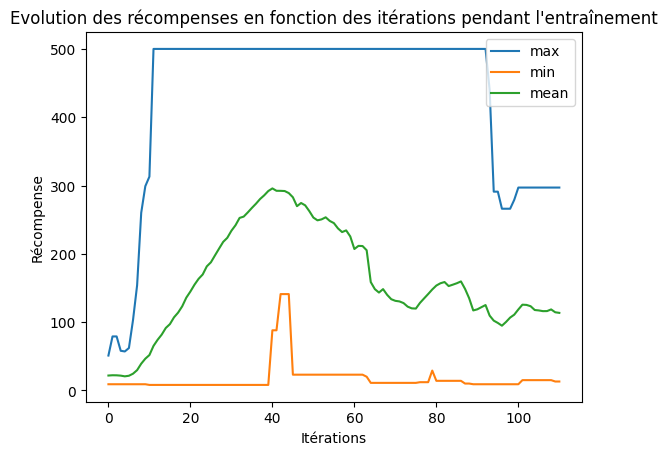

In [86]:
df1 = pd.read_csv('/content/drive/MyDrive/Stage_M2/Resultats_rllib/dqn_cartpole_setpoint_mode_-1/DQN_custom_env_99c23_00000_0_2024-01-11_14-13-32/progress.csv', usecols=[0, 1, 2])
plt.plot(range(len(df1)),df1.iloc[:,0],label='max')
plt.plot(range(len(df1)),df1.iloc[:,1],label='min')
plt.plot(range(len(df1)),df1.iloc[:,2],label='mean')
plt.xlabel("Itérations")
plt.ylabel("Récompense")
plt.title("Evolution des récompenses en fonction des itérations pendant l'entraînement")
plt.legend()
plt.show()

## DQN Mode 0 - étalon

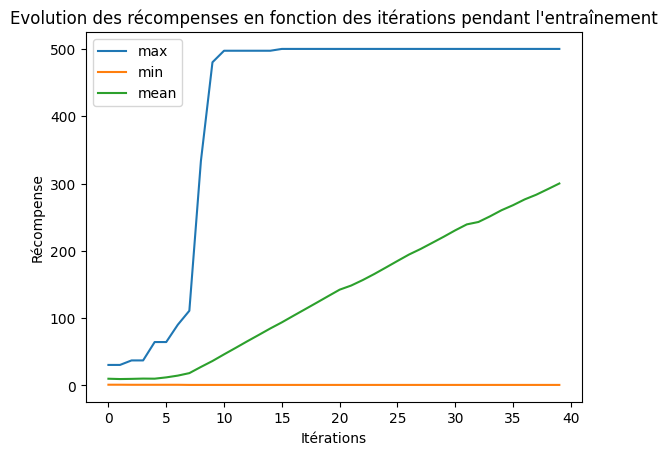

In [83]:
df1 = pd.read_csv('/content/drive/MyDrive/Stage_M2/Resultats_rllib/dqn_cartpole_setpoint_mode_0/DQN_custom_env_3ef7f_00000_0_2024-01-11_16-12-41/progress.csv', usecols=[0, 1, 2])
plt.plot(range(len(df1)),df1.iloc[:,0],label='max')
plt.plot(range(len(df1)),df1.iloc[:,1],label='min')
plt.plot(range(len(df1)),df1.iloc[:,2],label='mean')
plt.xlabel("Itérations")
plt.ylabel("Récompense")
plt.title("Evolution des récompenses en fonction des itérations pendant l'entraînement")
plt.legend()
plt.show()

## DQN Mode 1 - Constant

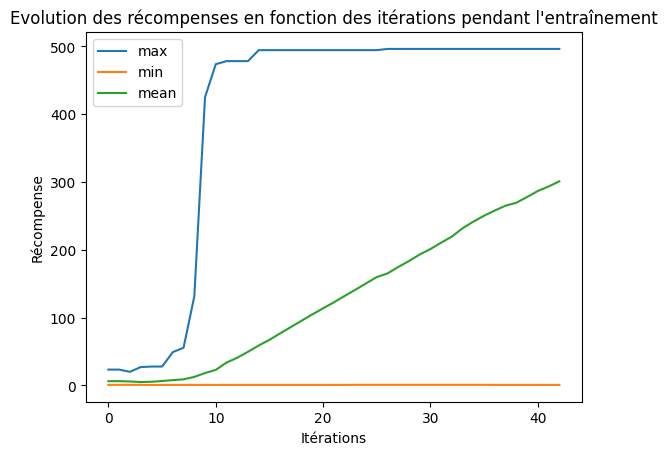

In [84]:
df1 = pd.read_csv('/content/drive/MyDrive/Stage_M2/Resultats_rllib/dqn_cartpole_setpoint_mode_1/DQN_custom_env_28b6b_00000_0_2024-01-12_10-20-08/progress.csv', usecols=[0, 1, 2])
plt.plot(range(len(df1)),df1.iloc[:,0],label='max')
plt.plot(range(len(df1)),df1.iloc[:,1],label='min')
plt.plot(range(len(df1)),df1.iloc[:,2],label='mean')
plt.xlabel("Itérations")
plt.ylabel("Récompense")
plt.title("Evolution des récompenses en fonction des itérations pendant l'entraînement")
plt.legend()
plt.show()

## DQN Mode 2 - Variable

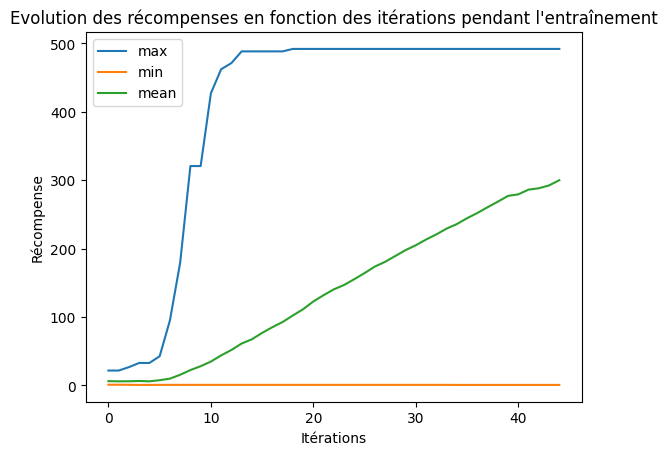

In [85]:
df1 = pd.read_csv('/content/drive/MyDrive/Stage_M2/Resultats_rllib/dqn_cartpole_setpoint_mode_2/DQN_custom_env_e59c2_00000_0_2024-01-12_11-51-18/progress.csv', usecols=[0, 1, 2])
plt.plot(range(len(df1)),df1.iloc[:,0],label='max')
plt.plot(range(len(df1)),df1.iloc[:,1],label='min')
plt.plot(range(len(df1)),df1.iloc[:,2],label='mean')
plt.xlabel("Itérations")
plt.ylabel("Récompense")
plt.title("Evolution des récompenses en fonction des itérations pendant l'entraînement")
plt.legend()
plt.show()

#Tests des agents

Dans cette section, nous allons charger les agents précédémment entrainés afin de les tester sur l'environnement avec consigne variable et mesurer leurs performances.

##Chargement des modèles depuis les checkpoints

In [10]:
#DQN mode -1
agent_1 = Algorithm.from_checkpoint("/content/drive/MyDrive/Stage_M2/Resultats_rllib/dqn_cartpole_setpoint_mode_-1/DQN_custom_env_99c23_00000_0_2024-01-11_14-13-32/checkpoint_000003")

2024-01-12 18:45:43,093	WARNING deprecation.py:50 -- DeprecationWarning: `rllib/algorithms/simple_q/` has been deprecated. Use `rllib_contrib/simple_q/` instead. This will raise an error in the future!
/usr/local/lib/python3.10/dist-packages/ray/rllib/algorithms/algorithm.py:483: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
`UnifiedLogger` will be removed in Ray 2.7.
  return UnifiedLogger(config, logdir, loggers=None)
/usr/local/lib/python3.10/dist-packages/ray/tune/logger/unified.py:53: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
The `JsonLogger interface is deprecated in favor of the `ray.tune.json.JsonLoggerCallback` interface and will be removed in Ray 2.7.
  self._loggers.append(cls(self.config, 

In [11]:
#DQN mode 0
agent0 = Algorithm.from_checkpoint("/content/drive/MyDrive/Stage_M2/Resultats_rllib/dqn_cartpole_setpoint_mode_0/DQN_custom_env_3ef7f_00000_0_2024-01-11_16-12-41/checkpoint_000001")

/usr/local/lib/python3.10/dist-packages/ray/rllib/algorithms/algorithm.py:483: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
`UnifiedLogger` will be removed in Ray 2.7.
  return UnifiedLogger(config, logdir, loggers=None)
/usr/local/lib/python3.10/dist-packages/ray/tune/logger/unified.py:53: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
The `JsonLogger interface is deprecated in favor of the `ray.tune.json.JsonLoggerCallback` interface and will be removed in Ray 2.7.
  self._loggers.append(cls(self.config, self.logdir, self.trial))
/usr/local/lib/python3.10/dist-packages/ray/tune/logger/unified.py:53: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppre

In [8]:
#DQN mode 1
agent1 = Algorithm.from_checkpoint("/content/drive/MyDrive/Stage_M2/Resultats_rllib/dqn_cartpole_setpoint_mode_1/DQN_custom_env_28b6b_00000_0_2024-01-12_10-20-08/checkpoint_000001")

2024-01-12 19:07:53,009	WARNING deprecation.py:50 -- DeprecationWarning: `rllib/algorithms/simple_q/` has been deprecated. Use `rllib_contrib/simple_q/` instead. This will raise an error in the future!
/usr/local/lib/python3.10/dist-packages/ray/rllib/algorithms/algorithm.py:483: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
`UnifiedLogger` will be removed in Ray 2.7.
  return UnifiedLogger(config, logdir, loggers=None)
/usr/local/lib/python3.10/dist-packages/ray/tune/logger/unified.py:53: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
The `JsonLogger interface is deprecated in favor of the `ray.tune.json.JsonLoggerCallback` interface and will be removed in Ray 2.7.
  self._loggers.append(cls(self.config, 

In [9]:
#DQN mode 2
agent2 = Algorithm.from_checkpoint("/content/drive/MyDrive/Stage_M2/Resultats_rllib/dqn_cartpole_setpoint_mode_2/DQN_custom_env_e59c2_00000_0_2024-01-12_11-51-18/checkpoint_000001")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/ray/rllib/algorithms/algorithm.py:483: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
`UnifiedLogger` will be removed in Ray 2.7.
  return UnifiedLogger(config, logdir, loggers=None)
/usr/local/lib/python3.10/dist-packages/ray/tune/logger/unified.py:53: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
The `JsonLogger inte

## Tests de généralisation

Les test vont consister à tester les capacité de généralisation des 4 agents sur un environnement personalisé avec consigne variable (mode 2)

In [10]:
# Environment
env = SetpointWrapper(setconfig)

###Agent témoin

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/gymnasium/envs/classic_control/cartpole.py:180: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
  logger.warn(


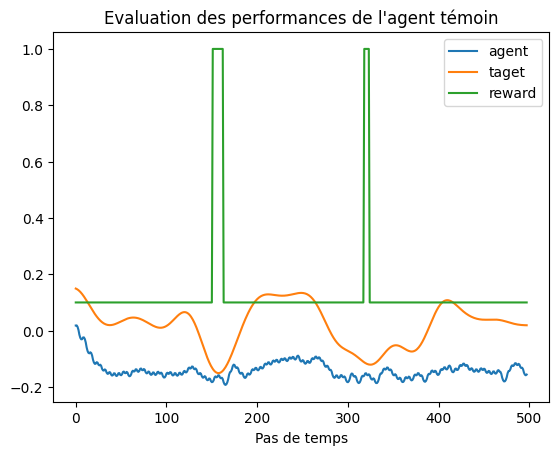

66.00000000000028


In [15]:
# simulation
for j in range (1):
  state, _ = env.reset()
  Y = [state[2:]]
  R = []
  for i in range(env._max_episode_steps-2) :
    action = agent_1.compute_single_action(state)
    state, reward, done, _, info = env.step(action)
    Y += [state[2:]]
    R += [reward]
    if done : break

  # plot
  plt.plot(range(env._elapsed_steps), Y[1:], label=["agent","taget"])
  plt.plot(range(env._elapsed_steps), R, label='reward')
  plt.xlabel("Pas de temps")
  plt.title("Evaluation des performances de l'agent témoin")
  plt.legend()
  plt.show()
  print(sum(R))

###Agent étalon

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/gymnasium/envs/classic_control/cartpole.py:180: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
  logger.warn(


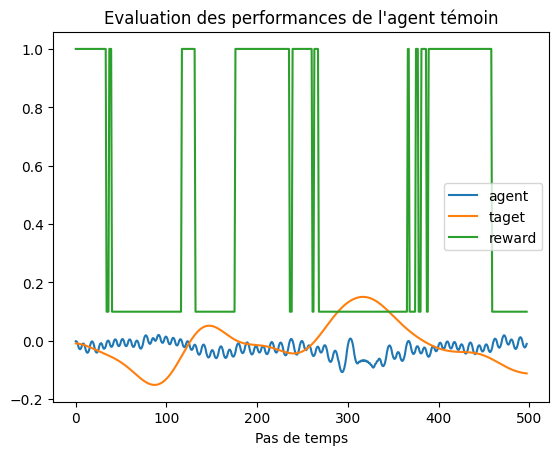

247.79999999999927


In [31]:
# simulation
for j in range (1):
  state, _ = env.reset()
  Y = [state[2:]]
  R = []
  for i in range(env._max_episode_steps-2) :
    action = agent0.compute_single_action(state)
    state, reward, done, _, info = env.step(action)
    Y += [state[2:]]
    R += [reward]
    if done : break

  # plot
  plt.plot(range(env._elapsed_steps), Y[1:], label=["agent","taget"])
  plt.plot(range(env._elapsed_steps), R, label='reward')
  plt.xlabel("Pas de temps")
  plt.title("Evaluation des performances de l'agent témoin")
  plt.legend()
  plt.show()
  print(sum(R))

###Agent constant

/usr/local/lib/python3.10/dist-packages/gymnasium/envs/classic_control/cartpole.py:180: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
  logger.warn(


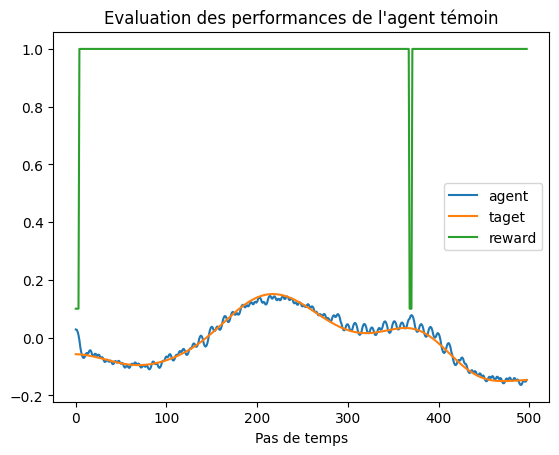

491.70000000000005


In [11]:
# simulation
for j in range (1):
  state, _ = env.reset()
  Y = [state[2:]]
  R = []
  for i in range(env._max_episode_steps-2) :
    action = agent1.compute_single_action(state)
    state, reward, done, _, info = env.step(action)
    Y += [state[2:]]
    R += [reward]
    if done : break

  # plot
  plt.plot(range(env._elapsed_steps), Y[1:], label=["agent","taget"])
  plt.plot(range(env._elapsed_steps), R, label='reward')
  plt.xlabel("Pas de temps")
  plt.title("Evaluation des performances de l'agent témoin")
  plt.legend()
  plt.show()
  print(sum(R))

###Agent variable

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/gymnasium/envs/classic_control/cartpole.py:180: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
  logger.warn(


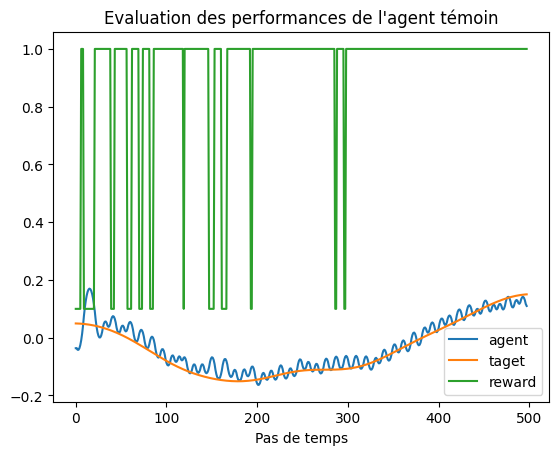

449.3999999999999


In [22]:
# simulation
for j in range (1):
  state, _ = env.reset()
  Y = [state[2:]]
  R = []
  for i in range(env._max_episode_steps-2) :
    action = agent2.compute_single_action(state)
    state, reward, done, _, info = env.step(action)
    Y += [state[2:]]
    R += [reward]
    if done : break

  # plot
  plt.plot(range(env._elapsed_steps), Y[1:], label=["agent","taget"])
  plt.plot(range(env._elapsed_steps), R, label='reward')
  plt.xlabel("Pas de temps")
  plt.title("Evaluation des performances de l'agent témoin")
  plt.legend()
  plt.show()
  print(sum(R))

#A ne pas consulter (test affichage loss)

In [ ]:
env_name = "CartPole-v1"

config = {
    "env":env_name,
    "mode":0,
    "dim":2,
    "truncated":500}

In [ ]:
algo = dqn.DQN(env=SetpointWrapper, config={"env_config": config, "num_workers": 1, "num_gpus": 0})

In [ ]:
for i in tqdm(range(100)):
  result = algo.train()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
100%|██████████| 100/100 [1:07:49<00:00, 40.69s/it]


In [ ]:
from ray.tune.logger import pretty_print

beautiful_result = pretty_print(result)
print(beautiful_result)

agent_timesteps_total: 100000
connector_metrics:
  ObsPreprocessorConnector_ms: 0.013289451599121094
  StateBufferConnector_ms: 0.009793281555175781
  ViewRequirementAgentConnector_ms: 0.2593502998352051
counters:
  last_target_update_ts: 99501
  num_agent_steps_sampled: 100000
  num_agent_steps_trained: 3168000
  num_env_steps_sampled: 100000
  num_env_steps_trained: 3168000
  num_target_updates: 198
custom_metrics: {}
date: 2024-01-09_09-09-59
done: false
episode_len_mean: 92.34
episode_media: {}
episode_reward_max: 121.0
episode_reward_mean: 84.25
episode_reward_min: 5.0
episodes_this_iter: 9
episodes_total: 1477
hostname: 8849ec0c2dff
info:
  last_target_update_ts: 99501
  learner:
    default_policy:
      custom_metrics: {}
      diff_num_grad_updates_vs_sampler_policy: 98999.0
      learner_stats:
        allreduce_latency: 0.0
        cur_lr: 0.0005
        grad_gnorm: 0.2101079225540161
        max_q: 78.67259216308594
        mean_q: 75.54246520996094
        min_q: 2.2444450

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
